In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import pandas as pd
from astropy.io import fits, ascii
import astropy.units as u
import astropy.constants as c
from tqdm import trange
from astropy.table import Table
import astropy
import corner
from tqdm import trange
import time
from numpy.polynomial.chebyshev import Chebyshev
import os
import random
from scipy.stats import chisquare
from scipy.optimize import curve_fit
import pymc3 as pm
import matplotlib.animation as animation

Data downloaded from https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m/

In [2]:
if len(glob.glob("sdss_data/060+00/*.fits")) != 998:
    !rsync -r -a \
    --include "apStar-*.fits" --exclude "*" \
    --prune-empty-dirs --progress \
    rsync://data.sdss.org/dr16/apogee/spectro/redux/r12/stars/apo25m/060+00/ sdss_data/060+00
        
if len(glob.glob("sdss_data/M15/*.fits")) != 1334:
    !rsync -r -a \
    --include "apStar-*.fits" --exclude "*" \
    --prune-empty-dirs --progress \
    rsync://data.sdss.org/dr16/apogee/spectro/redux/r12/stars/apo25m/M15/ sdss_data/M15
        
if len(glob.glob("sdss_data/K2_C4_168-21/*.fits")) != 439:
    !rsync -r -a \
    --include "apStar-*.fits" --exclude "*" \
    --prune-empty-dirs --progress \
    rsync://data.sdss.org/dr16/apogee/spectro/redux/r12/stars/apo25m/K2_C4_168-21/ sdss_data/K2_C4_168-21
        
if len(glob.glob("sdss_data/N6791/*.fits")) != 265:
    !rsync -r -a \
    --include "apStar-*.fits" --exclude "*" \
    --prune-empty-dirs --progress \
    rsync://data.sdss.org/dr16/apogee/spectro/redux/r12/stars/apo25m/N6791/ sdss_data/N6791     
        
        
fits_060_00 = glob.glob("sdss_data/060+00/*.fits")
fits_M15 = glob.glob("sdss_data/M15/*.fits")
fits_K2_C4_168_21 = glob.glob("sdss_data/K2_C4_168-21/*.fits")
fits_N6791 = glob.glob("sdss_data/N6791/*.fits")
print("We downloaded", len(fits_060_00) + len(fits_M15) + len(fits_K2_C4_168_21) + len(fits_N6791), "files")

We downloaded 3036 files


In [3]:
def get_apogee_id(fits_path):
    """takes in a filepath according to how I saved the
    fits files and returns the apogee_id for the file"""
    apogee_id = fits_path.replace(".fits", "").replace("apStar-r12-", "").split("/")[2]
    return apogee_id

def get_apogee_ids(fits_list):
    """takes in a filepath according to how I saved the 
    fits files and returns a list of the apogee_id for 
    each file in the list"""
    apogee_ids = []
    for i in range(len(fits_list)):
        apogee_id = get_apogee_id(fits_list[i])
        apogee_ids.append(apogee_id)

    return apogee_ids

In [4]:
i = 461
directory = fits_060_00
name = directory[i].replace(".fits", "")
name = name.split("/")[2]
hdul = fits.open(directory[i])
hdul.info()

Filename: sdss_data/060+00/apStar-r12-2M19395986+2341280.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     158   ()      
  1                1 ImageHDU        13   (8575, 5)   float32   
  2                1 ImageHDU        13   (8575, 5)   float32   
  3                1 ImageHDU        13   (8575, 5)   int16   
  4                1 ImageHDU        13   (8575, 5)   float32   
  5                1 ImageHDU        13   (8575, 5)   float32   
  6                1 ImageHDU        13   (8575, 5)   float32   
  7                1 ImageHDU        13   (8575, 5)   float32   
  8                1 ImageHDU        29   (26,)   float64   
  9                1 BinTableHDU     90   1R x 33C   [93A, 3I, 36A, 3J, 3I, 3D, 3E, 3E, 3E, 3E, 2I, 2E, 2E, 2E, 2E, E, E, E, E, E, 3E, 3E, 3E, 3E, 3E, 3E, 3E, 2005E, 2005E, 401E, D, D, 401E]   


We want to read in a spectrum and reconstruct the wavelength array. We then want to plot this as flux vs wavelength.

I will use the data from `HDU1`, which contains information about the flux spectra. The first two rows are combined spectra with different weighting. The first row uses pixel based weighting and the second uses a more "global" weighting. 

For now, I will be using the first row (pixel based weighting). This will have the possibility of giving bad results if there are bad pixels during the data collection and is a problem that I may have to come back to correct.

In [5]:
flux_grid = hdul[1].data
flux_array= flux_grid[0]

Now that we have grabbed the array of fluxes, we need to construct the array of wavelengths. This information can be found in the `HDU1` header. The `CRVAL1` gives the first value of wavelength and `CDELT1` gives the step size between wavelengths. The wavelength array parameters are given in log-linear space, so to convert into physical units, we will need to raise 10 to the power of the value to end up with units of length. The units for the flux are 10^-17 erg/s/cm^2/Ang and are listed in the header as `BUNIT`.

In [6]:
def generate_wavelength_array(length, start, step):
    """generates a wavelength array based on the parameters
    provided by the fits files"""
    log_wavelength_array = np.zeros(length)

    # generate the wavelength array
    for i in np.arange(length):
        log_wavelength_array[i] = start + step*i

    wavelength_array = 10**log_wavelength_array
    return wavelength_array

The flux data is collected by three different chips: blue, green, and red. The boundaries of the chips were set according to the boundaries used in Section 2.3 of [Ness et al. 2015](https://arxiv.org/pdf/1501.07604.pdf).

In [7]:
def remove_gaps(wavelength):
    """returns the indices that correspond to wavelengths not 
    cut off by gaps in the chips. Chip boundaries were selected
    according to the boundaries in Ness et al. 2015"""
    correct_unit_wavelength = wavelength*1e-4 
    blue_interval = np.where((correct_unit_wavelength >= 1.515) & (correct_unit_wavelength <=1.580))
    green_interval= np.where((correct_unit_wavelength >= 1.589) & (correct_unit_wavelength <=1.643))
    red_interval  = np.where((correct_unit_wavelength >= 1.649) & (correct_unit_wavelength <=1.695))
    return blue_interval, green_interval, red_interval

In [8]:
length = hdul[1].header["NAXIS1"]
start  = hdul[1].header["CRVAL1"]
step   = hdul[1].header["CDELT1"]
unit   = hdul[1].header["BUNIT"]

wavelength_array = generate_wavelength_array(length, start, step)
b, g, r = remove_gaps(wavelength_array)

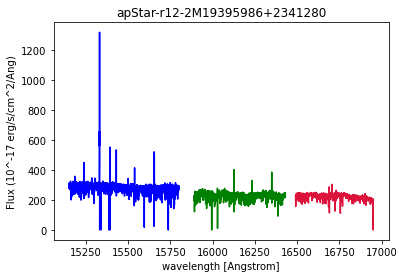

In [9]:
plt.figure()
plt.plot(wavelength_array[b], flux_array[b], color="blue")
plt.plot(wavelength_array[g], flux_array[g], color="green")
plt.plot(wavelength_array[r], flux_array[r], color="crimson")
plt.title(name)
plt.xlabel(r"wavelength [Angstrom]")
plt.ylabel(unit)
plt.show()

This spectrum has wavelength units in Angstroms $(10^{-10}m)$ and flux units of 10^-17 erg/s/cm^2/Ang

Now we will start gathering the data we need to build the training set. We will start by gathering a set of stellar properties ("labels"). These can be found in the [allStar catalog](https://data.sdss.org/datamodel/files/APOGEE_ASPCAP/APRED_VERS/ASPCAP_VERS/allStarLite.html), which we will now download. The labels for each star can be found in the allStar catalog. 

In [10]:
if len(glob.glob("allStarLite-r12-l33.fits")) == 0:
    !wget https://dr16.sdss.org/sas/dr16/apogee/spectro/aspcap/r12/l33/allStarLite-r12-l33.fits

In [11]:
allStar_table = Table.read("allStarLite-r12-l33.fits", format="fits")
print("The allStar table contains %s sources."%len(allStar_table))

The allStar table contains 473307 sources.


After downloading the table, we will reduce it, so that we are only dealing with the sources that we downloaded. The fields we will keep are `M15`, `K2_C4_168-21`, `N6791`, and `060+00`. We will then further reduce the contents of the table by removing sources who are lacking the following derived labels: `Teff`, `log g` `[Fe/H]`, `[Mg/Fe]`, `[Si/Fe]`. We will also make quality cuts on the data and keep only sources with signal-to-noise ratios above 50. And finally we will discard dwarf stars, which can be identified as having labels `log g` > 4 or `Teff` > 5700. We will also get rid of any stars with low metallicity: `M/H` < -1. 

In [12]:
M15_table = allStar_table[allStar_table["FIELD"] == "M15"]
M15_table.sort("APOGEE_ID")
fits_M15.sort()
M15_table["PATH"] = fits_M15

K2_C4_168_21_table = allStar_table[allStar_table["FIELD"] == "K2_C4_168-21"]
K2_C4_168_21_table.sort("APOGEE_ID")
fits_K2_C4_168_21.sort()
K2_C4_168_21_table["PATH"] = fits_K2_C4_168_21

N6791_table = allStar_table[allStar_table["FIELD"] == "N6791"]
N6791_table.sort("APOGEE_ID")
fits_N6791.sort()
N6791_table["PATH"] = fits_N6791

sixty_00_table = allStar_table[allStar_table["FIELD"] == "060+00"]
sixty_00_table.sort("APOGEE_ID")
fits_060_00.sort()
sixty_00_table["PATH"] = fits_060_00

In [13]:
def reduce_table(tbl):
    """remove rows which are mising derived labels for
    their composition, as well as those having Teff > 5700,
    log g > 4, SNR < 50 and M/H < -1"""
    not_derived = -9999.99
    tbl = tbl[tbl["TEFF"] <= 5700]
    tbl = tbl[tbl["LOGG"] <= 4]
    tbl = tbl[tbl["SNR"] >= 50]
    tbl = tbl[tbl["M_H"] != not_derived]
    tbl = tbl[tbl["MG_FE"] != not_derived]
    tbl = tbl[tbl["SI_FE"] != not_derived]
    tbl = tbl[tbl["TEFF"] != not_derived]
    tbl = tbl[tbl["M_H"] >= -1]
    return tbl

In [14]:
print("I started with %s stars. "%(len(M15_table)+len(N6791_table)+len(sixty_00_table)+len(K2_C4_168_21_table)))
M15_table = reduce_table(M15_table)
N6791_table = reduce_table(N6791_table)
sixty_00_table = reduce_table(sixty_00_table)
K2_C4_168_21_table = reduce_table(K2_C4_168_21_table)

all_tables = astropy.table.vstack([M15_table, sixty_00_table, N6791_table, K2_C4_168_21_table], join_type="exact")
remaining_fits_paths = list(all_tables["PATH"])
print("After reducing, I am left with %s stars."%len(all_tables))

I started with 3036 stars. 
After reducing, I am left with 1855 stars.


By making a cut on `log g`, I am able to effectively distinguish between dwarf and giant stars. According to the gravitational acceleration formula: $g = \frac{GM}{R^2}$, dwarf stars, which have a much smaller radius than giant stars will have a higher gravitational acceleration than a giant of equivalent mass. 

We can compare the labels by looking at a $1M_\odot$ star when it is on the main sequence $(R \sim 1R_\odot)$, just before its helium flash $(R \sim 100R_\odot)$, and during helium core burning $(R \sim 15 R_\odot)$. 

In [15]:
def log_g(M, R):
    """takes in the mass and radius of a star in 
    solar units and returns the log10 of the 
    surface gravity"""
    g = c.G*M*u.M_sun/(R*u.Rsun)**2
    return np.log10(g.to(u.meter/u.second**2).value)

In [16]:
radii = ["1R⊙", "100R⊙", "15R⊙"]
r = [1, 100, 15]
for i in range(3):
    print("log g(%s)  \t= %s"%(radii[i], np.round(log_g(1, r[i]), decimals=4)))

log g(1R⊙)  	= 2.4381
log g(100R⊙)  	= -1.5619
log g(15R⊙)  	= 0.0859


Now we will look at the distribution of the labels with respect to one another via a corner plot. Based on the plot, we can see that some labels are not closely related and produce a fairly circular corner plot, such as metallicity (`M_H`) vs effective temperature (`TEFF`) or log g (`LOGG`).

In [17]:
def corner_plot_prep(tbl, labels):
    columns = []
    for label in labels:
        columns.append(tbl[label])
    vstack = np.vstack(columns)
    transposed = np.transpose(vstack)
    return transposed, labels

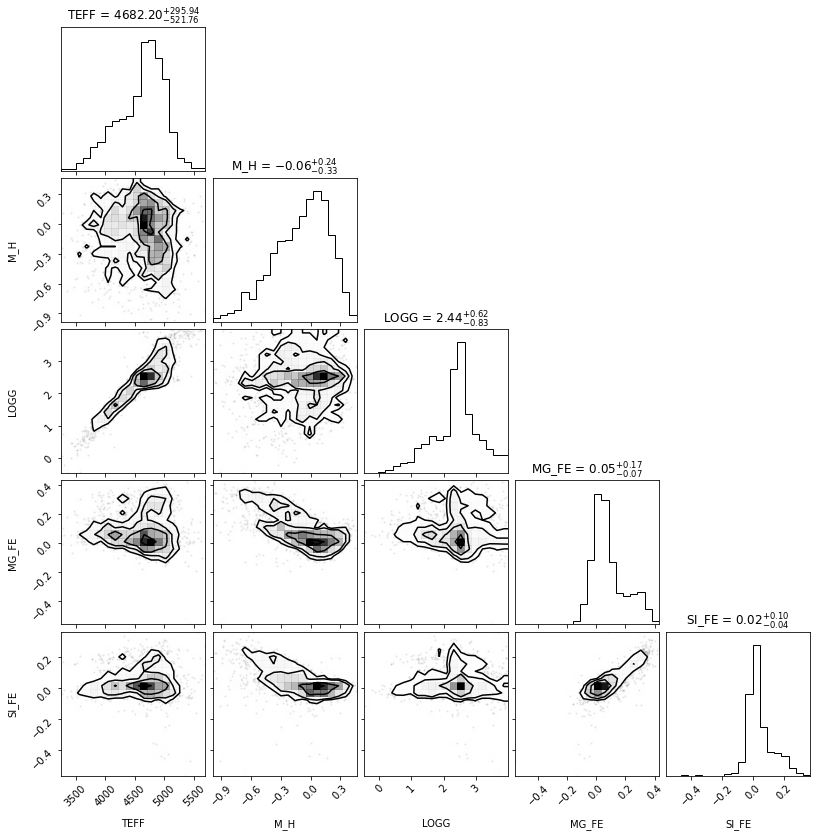

In [18]:
columns = ["TEFF", "M_H", "LOGG", "MG_FE", "SI_FE"]
data, labels = corner_plot_prep(all_tables, columns)
fig = corner.corner(data, labels=labels, 
                    show_titles=True, 
                    title_kwargs={"fontsize":12})
#plt.savefig("corner_plot.pdf")
plt.show()

In [19]:
def decimal_to_reversed_binary_list(decimal):
    """takes an array of ints and converts each number to binary, 
    creating an array with each bit having its own entry. For 
    simplicity, the array will be left reversed""" 
    m = 16
    binary_arr = (((decimal[:, None] & 1 << np.arange(m))) > 0).astype(int)
    return binary_arr

def is_bad_pixel_array(decimals):
    """determines whether a pixel is bad by checking the 
    truth values of bits 0-7 and 12. If any of these bits are
    true, then the pixel is marked as being bad for some reason"""
    binaries = decimal_to_reversed_binary_list(decimals)
    df = pd.DataFrame(binaries, 
                      columns=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15'])
    aa = np.sum(np.transpose(df[['0', '1', '2', '3', '4', '5', '6', '7']]))
    checks = aa+df["12"] 
    return np.asarray(checks > 0)

The meaning of each bit in the bitmask can be found [here](https://www.sdss.org/dr14/algorithms/bitmasks/#APOGEE_PIXMASK)

In [20]:
def set_errors(bitmask, errors):
    """reads the bitmask and sets the errors of the bad pixels
    to 1e+10 so that when weighting by inverse variance, they 
    will have very little effect relative to the good pixels"""
    bad_pixel = is_bad_pixel_array(bitmask)
    errors[bad_pixel] = 1.e+10
    return errors

Going through pixel by pixel, we must be aware of problems in the quality of the data. These quality issues are listed in a bitmask, which is a compact way of keeping track of a large number of boolean values. Bitmasks are [explained here](https://www.sdss.org/dr14/algorithms/bitmasks/), and the meaning of each bit in the bitmask can be found under the [APOGEE_PIXMASK: APOGEE](https://www.sdss.org/dr14/algorithms/bitmasks/#APOGEE_PIXMASK) dropdown. Of the 15 bits listed, we will use bits 0-7 and 12 to determine the quality of the pixel. 

Each `.fits` file contains information about the numebr of times a star was observed (`NVISITS` in the header [HDU0](https://data.sdss.org/datamodel/files/APOGEE_REDUX/APRED_VERS/stars/TELESCOPE/FIELD/apStar.html?fbclid=IwAR1Cdwpkv3-Ahak6hxz5gPqHlS-kzkCLZT1sN2Ai6rUSG_P96aJ5xoKu6cU#hdu0)), and if it was observed multiple times, the first two spectra are combined spectra with different weighting [HDU1](https://data.sdss.org/datamodel/files/APOGEE_REDUX/APRED_VERS/stars/TELESCOPE/FIELD/apStar.html?fbclid=IwAR1Cdwpkv3-Ahak6hxz5gPqHlS-kzkCLZT1sN2Ai6rUSG_P96aJ5xoKu6cU#hdu1). According to [Ness et al. 2015](https://arxiv.org/abs/1501.07604), our results can be improved by assigning a large error weight to the bad pixels. This error weighting should be done for individual visits and not for the combined spectra.

### Here I will update the error values for a fits file starting with the pathname

My hope is that I can store the changes in an object and keep the changes to errors without making changes to the actual file. 

In [21]:
a_fits_file = remaining_fits_paths[322]

def get_data_and_error(a_fits_file, known_id=True):
    """takes in a fits file and checks its bitmask and
    sets the errors according to the goodness of a pixel"""
    if known_id:
        source_id = get_apogee_id(a_fits_file)
    else:
        source_id = "mystery data"
    with fits.open(a_fits_file) as hdul:
        NVISITS = hdul[0].header["NVISITS"]
        LENGTH  = hdul[1].header["NAXIS1"]
        if NVISITS == 1:
            data_array = hdul[1].data
            error_array= hdul[2].data
            mask_array = hdul[3].data
            error_array = set_errors(mask_array, error_array)
            return source_id, np.asarray(data_array), np.asarray(error_array)
        else:
            #index = np.arange(2, 2+NVISITS)
            data_grid = hdul[1].data[0]
            error_grid= hdul[2].data[0]
            mask_grid = hdul[3].data[0]
            #for i in range(len(data_grid)):
            #    error_grid[i] = set_errors(mask_grid[i], error_grid[i])
            error_grid = set_errors(mask_grid, error_grid)
            return source_id, data_grid, error_grid

In [22]:
all_name_data_error = []

for i in trange(len(remaining_fits_paths)):
    name, d, e = get_data_and_error(remaining_fits_paths[i])
    outputs = [name, d, e]
    all_name_data_error.append(outputs)

100%|██████████| 1855/1855 [01:00<00:00, 30.50it/s]


Before fitting the spectra, we must first pseudo-continuum normalize them, according to the process in Ness et al. 2015. Pseudo-continuum normalization differs from true continuum normalization in that using a pseudo-continuum, we choose pixels whose flux is not affected by absorption features and use them to fit a normalization function to them. 

Unfortunately, the continuum wavelengths given in the `.npz` file do not exactly match with the wavelengths I have derived from the `.fits` file data. To force the data match the provided wavelengths, I will round both to the highest number of digits that make them match. I justify the rounding of the furthest decimal places based on the units that I am rounding. The units I am working with are Angstroms $(10^{-10}m)$, and the decimals that I am rounding to are between the 4th-6th decimal place, so the lengths corresponding to these decmial places are $10^{-14}m - 10^{-16}m$, which are likely beyond the tolerances of the instruments gathering the data, so I am okay with chopping off these values and not worried about throwing out important information. 

In [23]:
def continuum_indices(raw_data, continuum_data):
    """an iterative process to force the values of the 
    raw data wavelengths to match the wavelengths of the 
    provided continuum data by rounding the data and checking 
    if they match. If they do not match, the number of decimal 
    places is reduced by 1 and the process repeats"""
    n_decimal_places = 10
    keep = []
    
    while sum(keep) != len(continuum_data) and n_decimal_places >= 0:
        if sum(keep) != len(continuum_data):
            keep = []
        rounded_wl = np.round(raw_data, decimals=n_decimal_places)
        rounded_keep = np.round(continuum_data, decimals=n_decimal_places)

        for i in range(len(rounded_wl)):
            keep.append(rounded_wl[i] in rounded_keep)
        n_decimal_places += -1
    #print("The data was rounded to %s decimal places"%(n_decimal_places+1))
    if n_decimal_places < 0:
        print("SOMETHING WENT WRONG WITH MATCHING THE WAVELENGTHS")
    keep = np.asarray(keep)
    return keep

In [24]:
def chebyshev_normalize(fit_wl, fit_flux, raw_wl, raw_flux, errors=None):
    """computes a second order chebyshev polynomial fit
    to the fit data and returns the raw flux normalized
    by the fit
    
    returns the normalized raw flux and the line of best fit for 
    the raw flux"""
    # fit the polynomial
    if errors is None:
        p = Chebyshev.fit(fit_wl, fit_flux, 2)
    else:
        p = Chebyshev.fit(fit_wl, fit_flux, 2, w=errors**-2)
    
    #divide the raw flux by the interpolated fit 
    interp = p(raw_wl)
    normed = raw_flux / interp
    return normed, p

Now I will build a function that starts with a `.fits` file and computes the normalized, and error weighted spectrum. I will input an apogee_id, flux data, and error and it will output a pair of flux and wavelength for each of the three chips.

In [25]:
class Wavelength:
    """a class to calculate and compute the wavelength properties"""
    def __init__(self):
        # first generate the raw wavelength array
        self.data = generate_wavelength_array(8575, 4.179, 6e-06)
        
        #these are the indices of the raw data for each color chip
        self.colors = remove_gaps(self.data)
        
        # now read in the provided continuum data file
        self.provided_data = np.load("continuum_pixels_apogee.npz")
        self.provided_wavelengths = self.provided_data["wavelength"]
        self.provided_continuum_bool = self.provided_data["is_continuum"]
        self.continuum_wavelength_array = self.provided_wavelengths[self.provided_continuum_bool]
        
        self.raw_continuum_indices = continuum_indices(self.data,
                                                       self.continuum_wavelength_array)
        
        self.continuum_chips = remove_gaps(self.continuum_wavelength_array)

        
W = Wavelength()

In [26]:
def three_split(index, a, b, c):
    """splits three arrays of idential shape according
    to the index array provided"""
    return a[index], b[index], c[index]

def normalize_data(name, flux_data, errors_data, W):
    """Takes in the source name and raw flux data as well as the 
    corresponding errors, and a Wavelength object containing
    information about how to split up the data into the chips
    as well as which pixels are continuum values
    
    Returns the raw flux data, a list of the 
    normalized flux split up by chip, a list of the normalizing function
    and the source name
    
    The most important output is the normalized flux list"""
    
    # pick out the data that is in the continuum via indexing
    continuum_flux = flux_data[W.raw_continuum_indices]
    continuum_error= errors_data[W.raw_continuum_indices]
    
    # split the continuum data into its corresponding chips 
    chips = []
    for color in W.continuum_chips:
        color_continuum = three_split(color, W.continuum_wavelength_array, continuum_flux, continuum_error)
        chips.append(color_continuum)
    
    # normalize each chip
    out_flux , out_p , out_error = [], [], []
    for i, color in enumerate(chips):
        color_norm_flux, p_color = chebyshev_normalize(color[0], 
                                                  color[1], 
                                                  W.data[W.colors[i]], 
                                                  flux_data[W.colors[i]],       
                                                  color[2])
        out_error.append(errors_data[W.colors[i]]/p_color(W.data[W.colors[i]])) # normalize the error by 
                                                                                #   dividing by the 
                                                                                #  interpolation function
        out_flux.append(np.asarray(color_norm_flux))
        out_p.append(p_color)
    
    return np.asarray(flux_data), out_flux, out_p, name, out_error

Now we will test the code on source 2M19395986+2341280, to make sure that it is normalized properly.

In [27]:
for i, source in enumerate(all_name_data_error):
    if source[0] == "2M19395986+2341280":
        where = i
        print("Source 2M19395986+2341280 is at i=%s"%i)

Source 2M19395986+2341280 is at i=648


In [28]:
one_source = all_name_data_error[where]
W = Wavelength()

raw_flux, norm_flux, p_fit, name, norm_error = normalize_data(one_source[0], one_source[1], one_source[2], W)

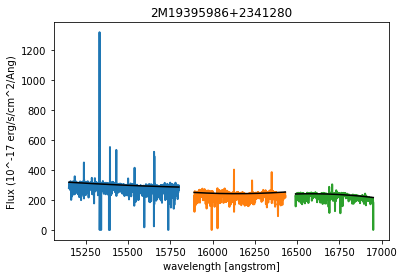

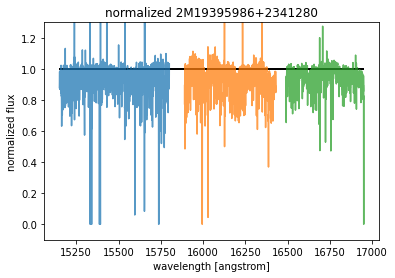

In [29]:
plt.figure()
for i in range(len(W.colors)):
    plt.plot(W.data[W.colors[i]], raw_flux[W.colors[i]], linewidth=2, label="raw data")
    plt.plot(W.data[W.colors[i]], p_fit[i](W.data[W.colors[i]]),color="black", label="2nd order chebyshev fit")
plt.title(name)
plt.xlabel("wavelength [angstrom]")
plt.ylabel(unit)
plt.show()

plt.figure()
for i in range(len(W.colors)):
    plt.plot(W.data[W.colors[i]], norm_flux[i], alpha=0.75)
plt.xlabel("wavelength [angstrom]")
plt.ylabel("normalized flux")
plt.ylim(-0.1, 1.3)
plt.hlines(1, min(W.data[W.colors[0]]), max(W.data[W.colors[2]]), linewidth=2,  color="black")
plt.title("normalized "+name)
plt.show()

In [30]:
# get max values for each label
max_logg = np.mean(all_tables["LOGG"])
max_teff = np.mean(all_tables["TEFF"])
max_fe_h = np.mean(all_tables["FE_H"])
max_mg_fe= np.mean(all_tables["MG_FE"])
max_si_fe= np.mean(all_tables["SI_FE"])

label_means = {"TEFF":max_teff, "LOGG":max_logg, "FE_H":max_fe_h, "MG_FE":max_mg_fe, "SI_FE":max_si_fe}
LABEL_MEANS = np.asarray([max_teff, max_logg, max_fe_h, max_mg_fe, max_si_fe])

W = Wavelength()
for i in range(1):
    normed_sources = []

    for source in all_name_data_error:
        # normalize the data
        one_normalization = []
        raw_flux, normed_flux, polynomial_fn, source_name, normed_error = normalize_data(source[0],
                                                                                         source[1], 
                                                                                         source[2], 
                                                                                         W)

        # get the label parameters from all_tables
        source = all_tables[all_tables["APOGEE_ID"] == source_name]
        teff = source["TEFF"]/max_teff
        logg = source["LOGG"]/max_logg
        fe_h = source["FE_H"]/max_fe_h
        mg_fe= source["MG_FE"]/max_mg_fe
        si_fe= source["SI_FE"]/max_si_fe
        snr  = source["SNR"]

        labels = {"TEFF": float(teff), "LOGG": float(logg), "FE_H": float(fe_h),
                  "MG_FE": float(mg_fe), "SI_FE": float(si_fe), "SNR": float(snr)}

        # put everything together 
        combine_name_flux_error = [source_name, normed_flux, labels, normed_error]
        normed_sources.append(combine_name_flux_error)
    
    np.random.seed(69)
    np.random.shuffle(normed_sources)
    train_data = normed_sources[927:]
    validation_data = normed_sources[:927]

    training_labels = []
    for source in train_data:
        name = source[0]
        training_labels.append(name)

    validation_labels = []
    for source in validation_data:
        name = source[0]
        validation_labels.append(name)

    check = "2M03533659+2512012"
    print(check in training_labels)

True


The resulting list has a rather complicate storage system:

The first index corresponds to the source number and has indices 0-1854

The second index selects either a list of either normalized flux, errors, or the labels. This has indices`0` for the source name, `1` for the normalized flux, `2` for the dictionary of order unity labels, and `3` for the error at each .

The third index selects the chip that the corresponding flux/wavelength data corresponds to. This index runs from 0-2. Index `0` corresponds to the "blue" chip (wavelengths between $1.514 \mu m$ and $1.581 \mu m$, index `1` corresponds to the "green" chip (wavelengths between $1.585 \mu m$ and $1.644 \mu m$), and index `2` corresponds to the "red" chip (wavelengths between $1.647 \mu m$ and $1.696 \mu m$). 

### Fitting a model to the data

We will start by considering a single pixel with wavelength $\lambda$, with $\textbf{f}_\lambda$ being an array containing the normalized flux in that pixel for all stars in the set. We will show that at a fixed value of $s_\lambda$, we can find the spectral model for the pixel via the linear equation $\textbf{X}\theta_\lambda = \textbf{f}_\lambda$, where $\theta_\lambda$ is an array of model parameters for that pixel and $\textbf{X}$ is a matrix that is the same for all labels. 

I will start by showing how the parts of the equation come together for the case where the model is linear in the labels. I will start with a single source, then add a second and from there, show that it can be generalized up to $n$ sources and will hold for more complicated models of the labels. 

\begin{equation}
    \begin{bmatrix}
    f \\
    \end{bmatrix}
    =
    \begin{bmatrix}
    1 & T_{eff} & log_{10}(g) & Fe/H & Mg/Fe & Si/Fe \\
    \end{bmatrix}
    \begin{bmatrix}
    C_0 \\
    C_1 \\
    C_2 \\
    C_3 \\
    C_4 \\
    C_5 \\
    \end{bmatrix}
\end{equation}

Which when multiplied out gives:

\begin{equation}
    f = C_0 + C_1 * T_{eff} + C_2 * log_{10}(g) + C_3* Fe/H + C_4 * Mg/Fe + C_5 * Si/Fe
\end{equation}

Now with two sources:

\begin{equation}
    \begin{bmatrix}
    f_0 \\
    f_1 \\
    \end{bmatrix}
    =
    \begin{bmatrix}
    1 & T_{eff_0} & log_{10}(g)_0 & Fe/H_0 & Mg/Fe_0 & Si/Fe_0 \\
    1 & T_{eff_1} & log_{10}(g)_1 & Fe/H_1 & Mg/Fe_1 & Si/Fe_1 \\
    \end{bmatrix}
    \begin{bmatrix}
    C_0 \\
    C_1 \\
    C_2 \\
    C_3 \\
    C_4 \\
    C_5 \\
    \end{bmatrix}
\end{equation}

Which when multiplied out gives:

\begin{equation}
    \begin{bmatrix}
    f_0 \\
    f_1 \\
    \end{bmatrix}
    =
    \begin{bmatrix}
    C_0 + C_1 * T_{eff_0} + C_2 * log_{10}(g)_0 + C_3 * Fe/H_0 + C_4 * Mg/Fe_0 + C_5 * Si/Fe_0 \\
    C_0 + C_1 * T_{eff_1} + C_2 * log_{10}(g)_1 + C_3 * Fe/H_1 + C_4 * Mg/Fe_1 + C_5 * Si/Fe_1 \\
    \end{bmatrix}
\end{equation}

Now generalizing this to $n$ sources with higher order dependences on the labels gives us:

\begin{equation}
    \begin{bmatrix}
    f_0 \\
    f_1 \\
    \vdots \\
    f_n \\
    \end{bmatrix}
    =
    \begin{bmatrix}
    1 & T_{eff_0} & ... & Si/Fe_0 & T_{eff_0}^2 & ... & Si/Fe_0^2 \\
    1 & T_{eff_1} & ... & Si/Fe_1 & T_{eff_1}^2 & ... & Si/Fe_1^2 \\
    \vdots & \vdots & \ddots & \vdots & \vdots & \ddots & \vdots \\
    1 & T_{eff_n} & ... & Si/Fe_n & T_{eff_n}^2 & ... & Si/Fe_n^2 \\
    \end{bmatrix}
    \begin{bmatrix}
    C_0 \\
    C_1 \\
    \vdots \\
    C_k \\
    \end{bmatrix}
\end{equation}

Which takes the form $\textbf{f}_\lambda = \textbf{X}\theta_\lambda$, where $\textbf{X}$ is the matrix of source labels and will not change from one wavelength (pixel) to the next. The matrix $\textbf{X}$ will have 21 entries in it. The first entry will be the number 1, to allow for any constant offset in the linear fit. The next five entries will be the labels `TEFF`, `LOGG`, `FE_H`, `MG_FE`, and `SI_FE`. The remaining 15 entries will be the second order labels and their "cross terms". Explicitly, a single row of $\textbf{X}$ is 

$\text{[1, TEFF, LOGG, FE_H, MG_FE, SI_FE, TEFF^2, LOGG^2, FE_H^2, MG_FE^2, SI_FE^2, TEFF*LOGG, TEFF*FE_H, TEFF*MG_FE, TEFF*SI_FE, LOGG*FE_H, LOGG*MG_FE, LOGG*SI_FE, FE_H*MG_FE, FE_H*SI_FE, MG_FE*SI_FE]}$

Each row of $\textbf{X}$ will be composed of the labels from a single source. Since the labels for a source will not change, $\textbf{X}$ will be the same for each pixel, while $\textbf{f}$ and $\theta_\lambda$ will change. The vector $\theta_\lambda$ is the vector of coefficients, which will be uniquely determined for each wavelength (pixel).

In [31]:
# generate a single row of the labels matrix
def make_label_grid(data):
    """generates a second order polynomial in labels
    of the known sorces for a single pixel across all
    sources in the data set"""
    matrix = []
    for source in data:
        lb = source[2]
        a_row = [1, lb["TEFF"], lb["LOGG"], lb["FE_H"], lb["MG_FE"], lb["SI_FE"],
                lb["TEFF"]**2, lb["LOGG"]**2, lb["FE_H"]**2, lb["MG_FE"]**2, lb["SI_FE"]**2,
                lb["TEFF"]*lb["LOGG"], lb["TEFF"]*lb["FE_H"], lb["TEFF"]*lb["MG_FE"], lb["TEFF"]*lb["SI_FE"],
                lb["LOGG"]*lb["FE_H"], lb["LOGG"]*lb["MG_FE"], lb["LOGG"]*lb["SI_FE"],
                lb["FE_H"]*lb["MG_FE"], lb["FE_H"]*lb["SI_FE"],
                lb["MG_FE"]*lb["SI_FE"]]
        matrix.append(a_row)
    return np.array(matrix)

In [32]:
def get_pixel_vector(pixel, chip, data):
    """generates a vector of the given pixel's flux across all 
    sources in the data set"""
    pixels = []
    for source in data:
        flux_chips = source[1]
        #n_pixels = len(flux_chips[0]) + len(flux_chips[1]) + len(flux_chips[2])
        one_pixel = flux_chips[chip][pixel] # takes a flux pixel from the first chip
        pixels.append(one_pixel)
    return np.asarray(pixels)

In [33]:
def get_sigma_vector(pixel, chip, data):
    """generates a vector of the given pixel's error across all 
    sources in the data set"""
    pixels = []
    for source in data:
        error_chips = source[3]
        #n_pixels = len(flux_chips[0]) + len(flux_chips[1]) + len(flux_chips[2])
        one_pixel = error_chips[chip][pixel] # takes a flux pixel from the first chip
        pixels.append(one_pixel)
    return np.asarray(pixels)

In [34]:
def log_likelihood(flux, labels_grid, coeffs, uncertainty_grid):
    log_p = -0.5*(flux - labels_grid.dot(coeffs))**2/(uncertainty_grid) - 0.5*np.log(uncertainty_grid)
    return np.sum(log_p, axis=1) # return the sum of the likelihood over all sources

In [35]:
W.data[W.colors[2]].shape

(1991,)

In [36]:
rng = len(W.data[W.colors[0]])
rng

3041

In [38]:
def chip_coeff(chip, labels_grid, train_data):
    W = Wavelength()
    rng = len(W.colors[chip][0])
    coeff_list, s2_list = [], []
    labels_grid_T = labels_grid.T
    
    #generate a grid of all s_lambda values to be tested
    s = np.linspace(0, 0.2, num=1000, endpoint=True)
    s_grid = []
    for i in range(len(train_data)):
        s_grid.append(s)
    s_grid = np.array(s_grid)
    
    for ii in trange(rng):
        px_vector = get_pixel_vector(ii, chip, train_data)
        err_vector = get_sigma_vector(ii, chip, train_data)
        
        C1 = np.diag(err_vector**-2)
        XTC1 = np.einsum("ij,jk->ik", labels_grid_T, C1)
        LHS = np.einsum("ij,jk->ik", XTC1, labels_grid)
        RHS = np.einsum("ij,j->i", XTC1, px_vector)
        coeff = np.linalg.solve(LHS, RHS)
        coeff_list.append(coeff)
        
        uncertainty_grid = (err_vector**2 + s_grid.T**2) 
        log_likely = log_likelihood(px_vector, labels_grid, coeff, uncertainty_grid)
        best_s_index = np.argmax(log_likely)
        s2_list.append(s[best_s_index]**2)
        
    return np.array(coeff_list), np.array(s2_list)

In [39]:
def get_coefficients(train_data):
    labels_grid = make_label_grid(train_data)
    coefficients_list, s2_list = [], []
    
    for i in range(3):
        c, s2 = chip_coeff(i, labels_grid, train_data)
        coefficients_list.append(c)
        s2_list.append(s2)
    return np.array(coefficients_list), np.array(s2_list)

In [40]:
MODEL_COEFF, s2 = get_coefficients(train_data)

100%|██████████| 1991/1991 [01:15<00:00, 26.28it/s]


In [41]:
# these give the same result
# labels_grid.dot(coeff)
# np.einsum("ij,j->i", labels_grid, coeff)

In [42]:
def make_linear_equation(source, chip):
    fluxes = []
    labels_grid = []
    chip_flux = source[1][chip]
    lb = source[2] # the dictionary of label values 
    
    labels = [1, lb["TEFF"], lb["LOGG"], lb["FE_H"], lb["MG_FE"], lb["SI_FE"],
            lb["TEFF"]**2, lb["LOGG"]**2, lb["FE_H"]**2, lb["MG_FE"]**2, lb["SI_FE"]**2,
            lb["TEFF"]*lb["LOGG"], lb["TEFF"]*lb["FE_H"], lb["TEFF"]*lb["MG_FE"], lb["TEFF"]*lb["SI_FE"],
            lb["LOGG"]*lb["FE_H"], lb["LOGG"]*lb["MG_FE"], lb["LOGG"]*lb["SI_FE"],
            lb["FE_H"]*lb["MG_FE"], lb["FE_H"]*lb["SI_FE"],
            lb["MG_FE"]*lb["SI_FE"]]
        
    return chip_flux, np.array(labels)

In [43]:
def test_driver(source_number, coefficients, W):
    tst_source = train_data[source_number]
    
    plt.figure()
    plt.xlabel("Wavelength [angstrom]")
    plt.ylabel("Normalized Flux ")
    plt.title(tst_source[0])
    for i in range(len(coefficients)):
        raw_flux, labels = make_linear_equation(tst_source, i)
        dummy_flux = coefficients[i].dot(labels)

        plt.plot(W.data[W.colors[i]], raw_flux, label="true", color="black", alpha=0.75)
        plt.plot(W.data[W.colors[i]], dummy_flux, label="predicted", alpha=0.75, color="crimson")
    plt.legend()
    plt.ylim(-0.1, 1.3)
    plt.xlim(16000, 16100)

In [44]:
print("Searching for source", check)

for i, source in enumerate(train_data):
    if source[0] == check:
        print(check, "found at index %s"%i)

Searching for source 2M03533659+2512012
2M03533659+2512012 found at index 27


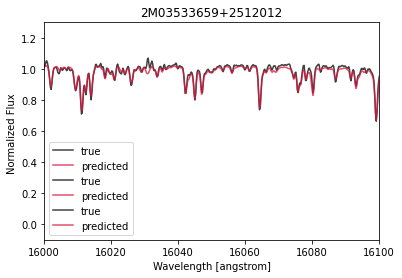

In [45]:
test_driver(27, MODEL_COEFF, W)
#plt.savefig("fit_vs_raw_%s.pdf"%check)

In [46]:
def predict_spectrum(coefficients, labels, W, plot=False):
    """takes in the existing coefficients that connect the 
    stellar labels to the observed fluxes and predicts the 
    specrum based on an arbitrary set of labels"""
    chip_flux = []
    
    for i, color in enumerate(coefficients):
        temp_flux = color.dot(labels)
        chip_flux.append(temp_flux)
        if plot:
            plt.plot(W.data[W.colors[i]], temp_flux)
            
    if plot:
        plt.xlabel("wavelength [angstrom]")
        plt.ylabel("normalized flux")
        plt.title("predicted spectrum")
    
    return chip_flux

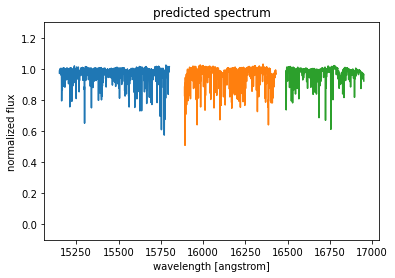

In [47]:
f, l = make_linear_equation(train_data[27],0)
_ = predict_spectrum(MODEL_COEFF, l, W, plot=True) # need to figure out why the chip flux is null 
plt.ylim(-0.1, 1.3)
plt.show()

In [48]:
def get_gradient(index, coefficients, W):
    chip_coeff = []
    for i in range(3):
        px_coeff = []
        for j in range(len(W.data[W.colors[i]])):
            px_coeff.append(coefficients[i][j][index])
        print("done with chip %s"%i)
        chip_coeff.append(np.array(px_coeff))
    return np.array(chip_coeff)

Next, we will look at how the spectrum is dependant on each label. This will be done by examining the gradient spectrum, $df_\lambda/dl_i$, where $l_i$ is one of the labels. 

In [49]:
temp = MODEL_COEFF[0]
label = 1
the_coefficients = np.zeros(len(temp))
for i, pixel in enumerate(temp):
    #coeff_value = pixel[label]
    the_coefficients[i] = pixel[label]
the_coefficients.shape

(3041,)

In [50]:
def gradient_spectrum(label, coefficients):
    """takes in the index of a label and the set
    of fitted coefficients, and returns the gradient
    of the fit with respect to the label"""
    chips = [] 
    for chip in coefficients:
        the_coeffs = np.zeros(len(chip))
        for i, pixel in enumerate(chip):
            the_coeffs[i] = pixel[label]
        chips.append(the_coeffs)
    return np.array(chips)

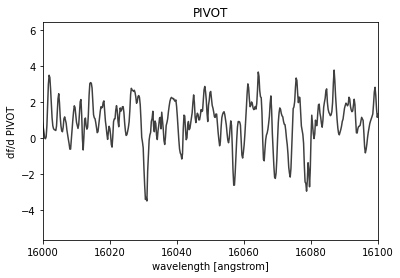

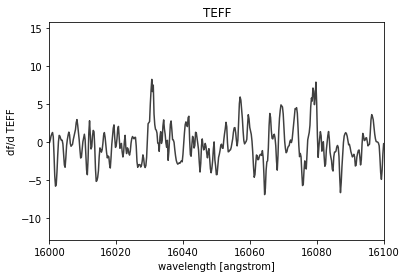

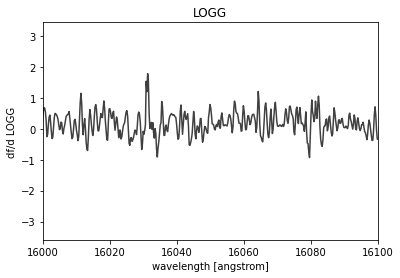

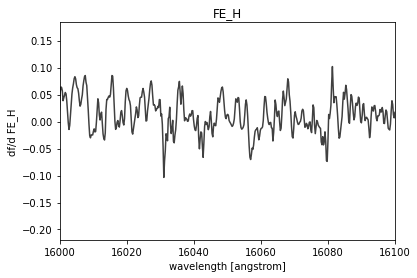

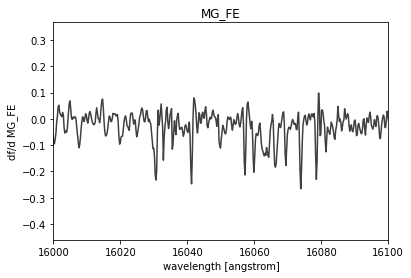

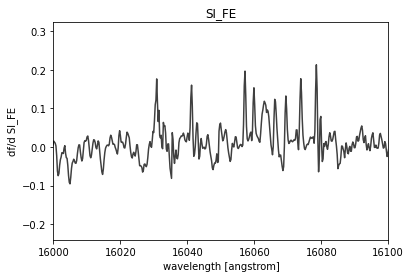

In [51]:
labels = ["PIVOT", "TEFF", "LOGG", "FE_H", "MG_FE", "SI_FE"]
for j in np.arange(6):

    grad = gradient_spectrum(j, MODEL_COEFF)

    plt.figure()
    for i in range(3):
        plt.plot(W.data[W.colors[i]], grad[i], alpha=0.75, color="black")
    #plt.vlines(15047.71, -4, 4, label="Mg I")
    #plt.vlines(15888.431, -4, 4, label="Si I")
    plt.xlim(16000, 16100)
    #plt.legend()
    plt.xlabel("wavelength [angstrom]")
    plt.ylabel("df/d %s"%labels[j])
    plt.title(labels[j])

Now we will test how well our model works on the labels in the cross-validation set. 

In [52]:
def make_vector(TEFF, LOGG, FE_H, MG_FE, SI_FE):
    """generates a vector up to second order in 
    the five labels given"""
    labels = [1, TEFF, LOGG, FE_H, MG_FE, SI_FE,
            TEFF**2, LOGG**2, FE_H**2, MG_FE**2, SI_FE**2,
            TEFF*LOGG, TEFF*FE_H, TEFF*MG_FE, TEFF*SI_FE,
            LOGG*FE_H, LOGG*MG_FE, LOGG*SI_FE,
            FE_H*MG_FE, FE_H*SI_FE,
            MG_FE*SI_FE]
    return np.array(labels)

def merge_flux_data(source):
    """takes source entry from validation_data
    and condenses the flux data so that it is 
    in a single array """
    flux_data = source[1]
    return put_together(flux_data)

def merge_err_data(source):
    """takes source entry from validation_data
    and condenses the error data so that it is 
    in a single array """
    err_data = source[3]
    return put_together(err_data)

def put_together(arr):
    """takes a list of lists and puts the 
    contents together into a single array 
    with length equal to the sum of the lengths
    of the lists in `arr` """
    combined = np.asarray([])
    for lst in arr:
        combined = np.append(combined, lst)
    return combined

def predict(dummy, TEFF, LOGG, FE_H, MG_FE, SI_FE):
    # make the vector of labels
    labels = make_vector(TEFF, LOGG, FE_H, MG_FE, SI_FE)
    
    # get the true flux data 
    #true_flux = merge_flux_data(a_source)
    
    # put together all the model coefficients
    all_coeff = []
    for chip in MODEL_COEFF:
        for pixel in chip:
            all_coeff.append(pixel)
    all_coeff = np.asarray(all_coeff)
    
    return all_coeff.dot(labels)

In [54]:
def percent_diff(real, meas):
    return np.abs(real - meas)/real*100

In [55]:
num = 67
popt, pcov = curve_fit(predict, np.arange(7451), merge_flux_data(validation_data[num]), method="trf", bounds=(-10, 10))
true_labels = [validation_data[num][2]["TEFF"], validation_data[num][2]["LOGG"],
               validation_data[num][2]["FE_H"], validation_data[num][2]["MG_FE"],
               validation_data[num][2]["SI_FE"]]
true_labels = np.asarray(true_labels)


popt = popt*LABEL_MEANS
true_labels = true_labels*LABEL_MEANS

resid = list(popt - true_labels)
pdiff = list(percent_diff(true_labels, popt))
popt = list(popt)
true_labels = list(true_labels)

resid.insert(0, "RESID")
popt.insert(0, "FIT")
true_labels.insert(0, "TRUE")
pdiff.insert(0, "% DIFF")

data = [popt, true_labels, resid, pdiff]
df = pd.DataFrame(data, columns=["Measure", "TEFF", "LOGG", "FE_H", "MG_FE", "SI_FE"])
df

,Measure,TEFF,LOGG,FE_H,MG_FE,SI_FE
0,FIT,4752.589066,3.077744,-0.034328,-0.048572,0.015296
1,TRUE,5005.847141,2.696434,-0.166312,-0.014877,0.013743
2,RESID,-253.258076,0.381310,0.131984,-0.033695,0.001553
3,% DIFF,5.059245,14.141278,-79.359475,-226.485979,11.301848


In [56]:
def fit_and_true(data):
    popt, pcov = curve_fit(predict, np.arange(7451), 
                           merge_flux_data(data), 
                           sigma=merge_err_data(data),
                           method="trf", bounds=(-10, 10))
    true_labels = np.asarray([data[2]["TEFF"], data[2]["LOGG"],
                              data[2]["FE_H"], data[2]["MG_FE"],
                              data[2]["SI_FE"]])
    return popt, true_labels

In [57]:
fitts, reals = [], []

for i in trange(len(validation_data)):
    fitted, true = fit_and_true(validation_data[i])
    fitts.append(fitted)
    reals.append(true)

100%|██████████| 927/927 [16:34<00:00,  1.07s/it]


In [58]:
# np.save("fitts", fitts)
# np.save("reals", reals)
# fitts = np.load("fitts.npy")
# reals = np.load("reals.npy")

In [59]:
print("fitts:  ", len(fitts))
print("reals:  ", len(reals))

fitts:   927
reals:   927


In [60]:
def get_predict(fitted, true, label):
    label_dict = {"TEFF":0, "LOGG":1, "FE_H":2, "MG_FE":3, "SI_FE":4}
    fitted_values = np.zeros(len(fitted))
    true_values = np.zeros(len(true))
    
    for i in range(len(fitted)):
        fitted_values[i] = fitted[i][label_dict[label]]
        true_values[i] = true[i][label_dict[label]]
        
    return fitted_values, true_values

In [91]:
def rms(array):
    return np.sqrt(np.mean(array**2))

def plot_and_residuals(label, fitts, reals):
    
    fitts = fitts*LABEL_MEANS
    reals = reals*LABEL_MEANS
    
    fitted_label, true_label = get_predict(fitts, reals, label)
    
    min_val = min(true_label)
    max_val = max(true_label)
    rnge = max_val - min_val
    
    x = np.linspace(min_val-0.1*rnge, max_val+0.1*rnge)
    residuals = fitted_label - true_label
    bias = np.mean(residuals)
    scatter = rms(residuals)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,6), sharex=True, 
                                   gridspec_kw={'height_ratios': [2, 1]})
    ax1.plot(x, x, color="black", alpha=0.75)
    ax1.scatter(true_label, fitted_label, s=1, label="bias=%s\nscatter=%s"%(np.round(bias, 4), np.round(scatter,4)))
    ax1.set_ylabel("fitted "+label)
    #ax1.set_ylim(min_val-rnge*0.1, max_val+rnge*0.1)
    ax1.legend()
    
    ax2.scatter(true_label, residuals, color="crimson", s=1)
    ax2.hlines(0, min_val-rnge*0.1, max_val+rnge*0.1, alpha=0.75, color="black")
    ax2.set_ylabel("residuals")
    
    plt.xlabel("ASPCAP "+label)
    plt.suptitle(label)
    #plt.xlim(min_val-rnge*0.1, max_val+rnge*0.1)

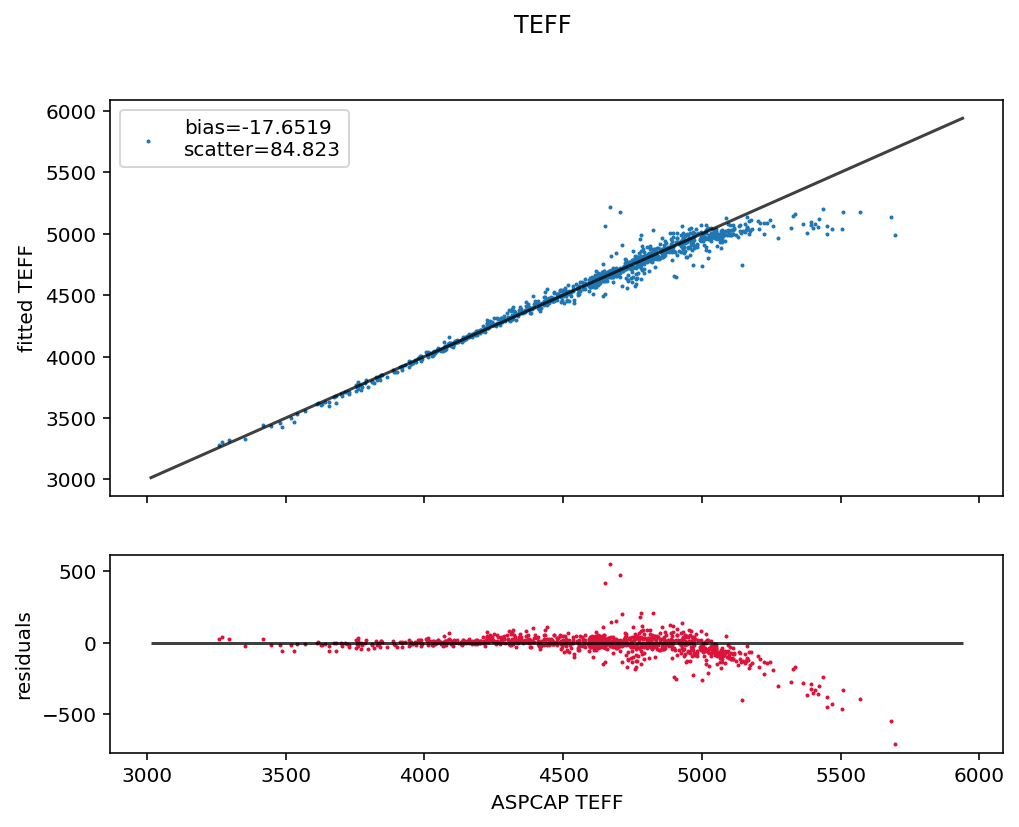

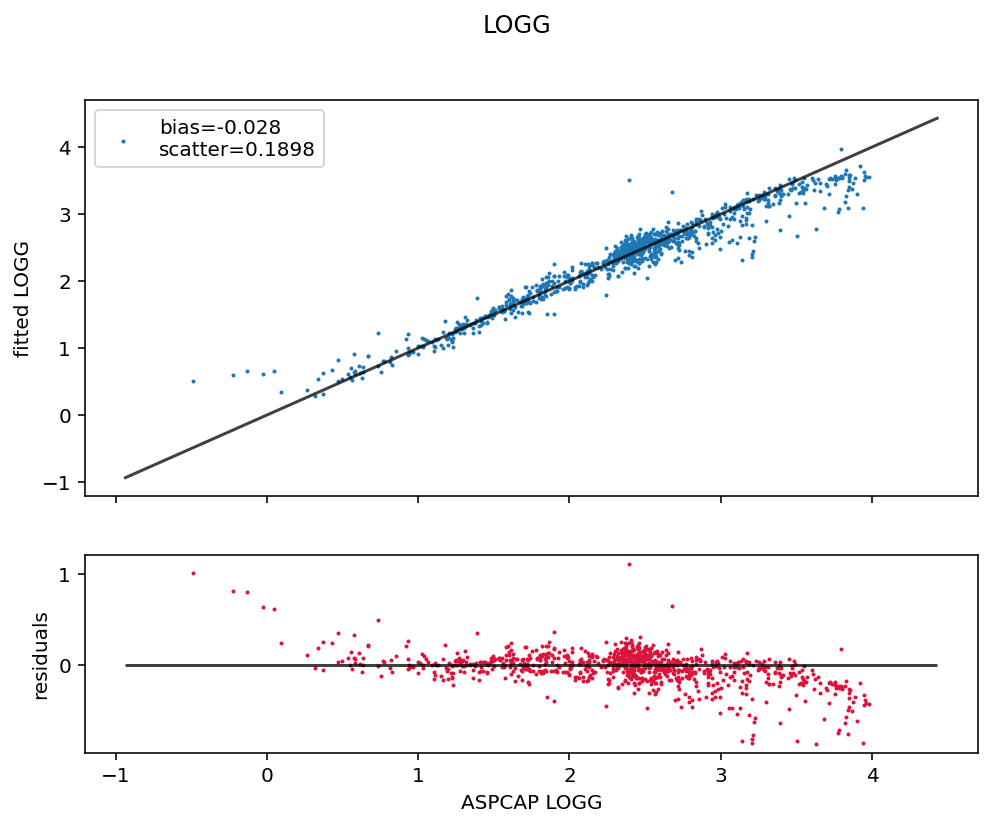

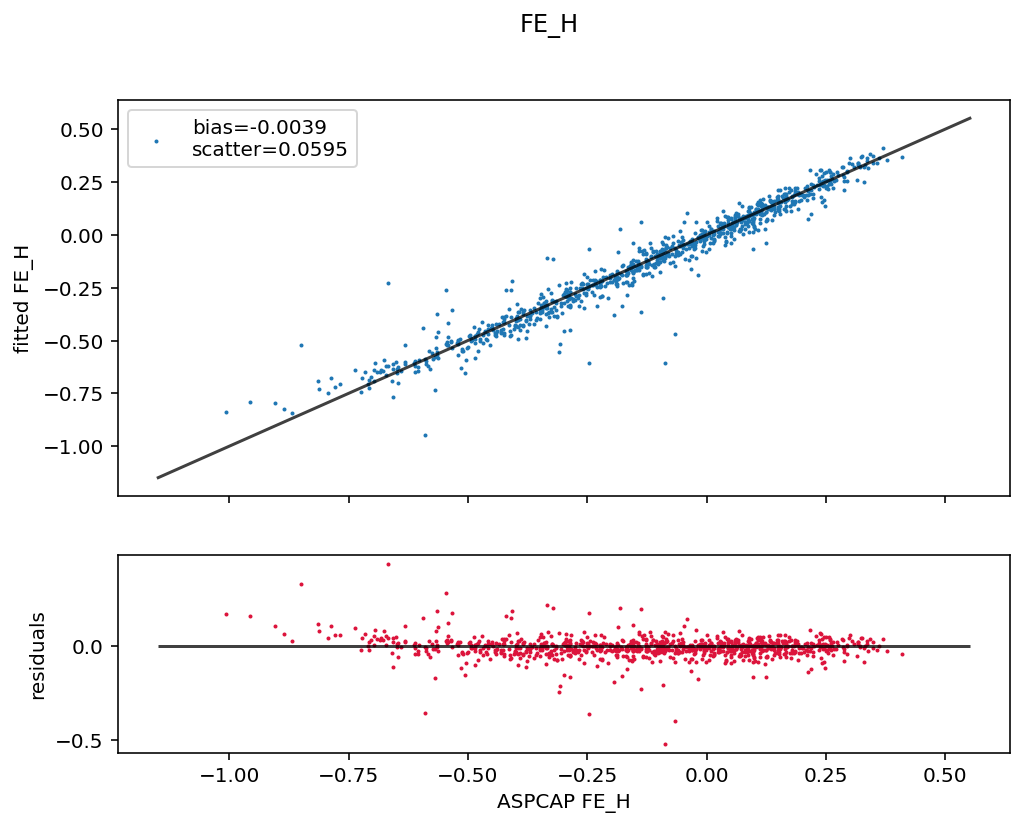

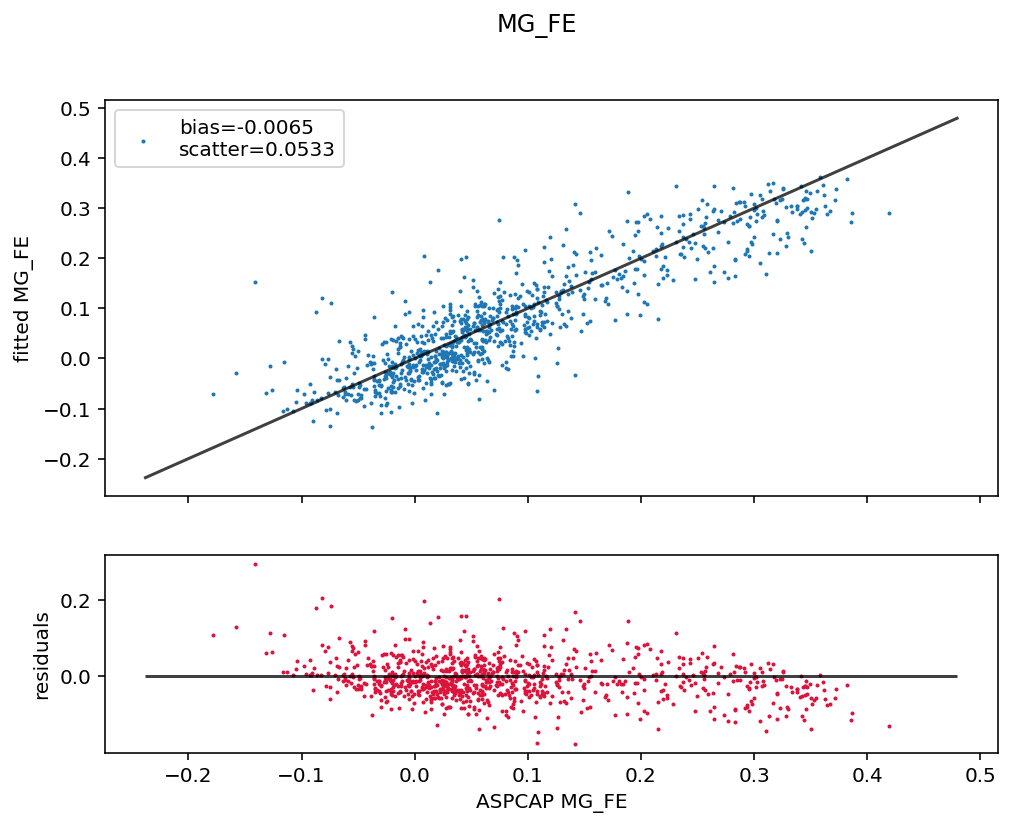

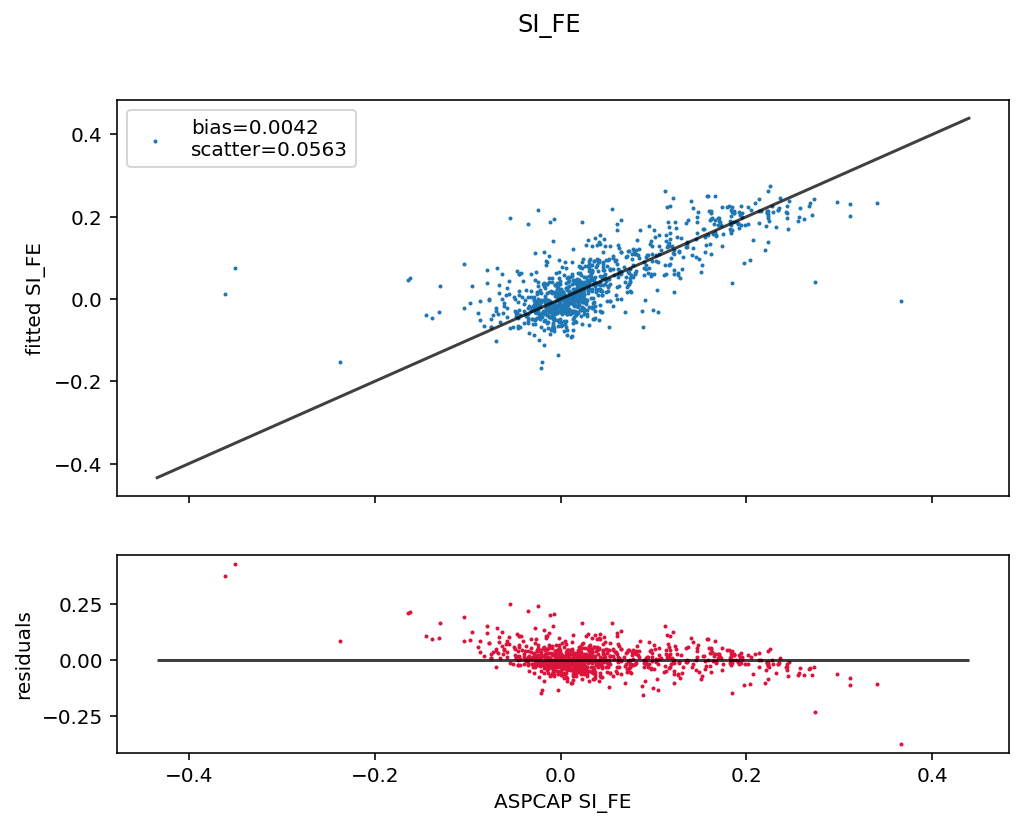

In [92]:
labels = ["TEFF", "LOGG", "FE_H", "MG_FE", "SI_FE"]

for label in labels:
    plot_and_residuals(label, fitts, reals)

In [63]:
os.system("wget http://waps.cfa.harvard.edu/MIST/tmp/MIST_iso_606facf1a8397.iso.zip")
os.system("unzip MIST_iso_606facf1a8397.iso.zip")
solar_metallicity = "MIST_iso_606facf1a8397.iso"

os.system("wget http://waps.cfa.harvard.edu/MIST/tmp/MIST_iso_606faf9c00b65.iso.zip")
os.system("unzip MIST_iso_606faf9c00b65.iso.zip")
metallicity_1 = "MIST_iso_606faf9c00b65.iso"

In [64]:
solar_tbl = Table.read(solar_metallicity, format='ascii', header_start=-1)
Z_1_tbl = Table.read(metallicity_1, format='ascii', header_start=-1)

In [65]:
solar_tbl = solar_tbl[solar_tbl["phase"]==2]
Z_1_tbl = Z_1_tbl[Z_1_tbl["phase"]==2]

In [66]:
solar_logg = solar_tbl["log_g"]
solar_teff = 10**solar_tbl["log_Teff"]
Z_1_logg = Z_1_tbl["log_g"]
Z_1_teff = 10**Z_1_tbl["log_Teff"]

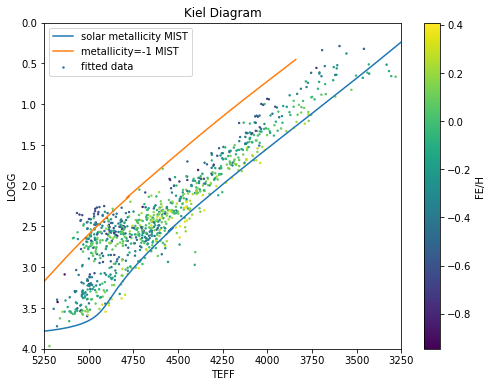

In [67]:
fitted_teff, _ = get_predict(fitts, reals, "TEFF")
fitted_logg, _ = get_predict(fitts, reals, "LOGG")
fitted_fe_h, _ = get_predict(fitts, reals, "FE_H")

fitted_teff = fitted_teff*label_means["TEFF"]
fitted_logg = fitted_logg*label_means["LOGG"]
fitted_fe_h = fitted_fe_h*label_means["FE_H"]

plt.figure(figsize=(8,6))
plt.plot(solar_teff, solar_logg, label="solar metallicity MIST")
plt.plot(Z_1_teff, Z_1_logg, label="metallicity=-1 MIST")
plt.scatter(fitted_teff, fitted_logg, c=fitted_fe_h, s=2, label="fitted data")
plt.xlabel("TEFF")
plt.ylabel("LOGG")
plt.title("Kiel Diagram")
plt.colorbar(label="FE/H")
plt.xlim((5250, 3250))
plt.legend()
plt.ylim((4,0));

My derived labels appear to have the majority of their values bounded between the isochrone of solar metallicity and the isochrone of Fe/H=-1. The coloring of the points shows the value of their metallicity, and it appears to be in agreement with the isochrones. The sources with the higher metallicity, (more yellow) are closer to the isochrone with solar metallicity, and the sources with lower metallicity tend to be closer to the isochrone with Fe/H=-1. 

Additionally, we can see that sources with a higher metallicity also have a surface gravity, and soruces with a lower metalicity have a lower surface gravity. One reason for this could be that stars with a higher metallicity are more dense than a star of similar radius with a lower metallicity. This higher density could result in a stronger gravitational field, which would cause a higher surface gravity.

In [69]:
all_coeff = []

for chip in MODEL_COEFF:
    for pixel in chip:
        all_coeff.append(pixel)
all_coeff = np.asarray(all_coeff)
all_coeff.shape

(7451, 21)

In [70]:
mystery_source = "mystery_spec_wiped.fits"

W = Wavelength()
mystery_id, mystery_data, mystery_error = get_data_and_error(mystery_source, known_id=False)
m_flux, m_normed_flux, m_poly, mystery_id, m_normed_error = normalize_data(mystery_id, mystery_data, mystery_error, W)
m_normed_flux = put_together(m_normed_flux)
m_normed_error= put_together(m_normed_error)

In [71]:
all_coeff.shape
m_normed_flux.shape

(7451,)

In [72]:
def calc_mu(all_coeff, TEFF, LOGG, FE_H, MG_FE, SI_FE):
    labels = make_vector(TEFF, LOGG, FE_H, MG_FE, SI_FE)
    return all_coeff.dot(labels)

In [75]:
s_lambda = put_together(s2)
s_lambda.shape

total_sigma = s_lambda**2 + m_normed_error**2

In [76]:
# np.save("all_coeff", all_coeff)
# np.save("m_normed_flux", m_normed_flux)
# np.save("total_sigma", total_sigma)

# all_coeff = np.load("all_coeff.npy")
# m_normed_flux = np.load("m_normed_flux.npy")
# total_sigma = np.load("total_sigma.npy")

In [77]:
def make_vector_2(TEFF, LOGG, FE_H, MG_FE, SI_FE):
    """generates a vector up to second order in 
    the five labels given"""
    labels = [1, TEFF, LOGG, FE_H, MG_FE, SI_FE,
            TEFF**2, LOGG**2, FE_H**2, MG_FE**2, SI_FE**2,
            TEFF*LOGG, TEFF*FE_H, TEFF*MG_FE, TEFF*SI_FE,
            LOGG*FE_H, LOGG*MG_FE, LOGG*SI_FE,
            FE_H*MG_FE, FE_H*SI_FE,
            MG_FE*SI_FE]
    return labels

In [131]:
label_means

{'TEFF': 4608.3315,
 'LOGG': 2.3619843,
 'FE_H': -0.116120525,
 'MG_FE': 0.08288146,
 'SI_FE': 0.03865677}

/Users/DanielBautista/opt/miniconda3/envs/astroconda/lib/python3.6/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [SI_FE, MG_FE, FE_H, LOGG, TEFF]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 101 seconds.
/Users/DanielBautista/opt/miniconda3/envs/astroconda/lib/python3.6/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/Users/DanielBautista/opt/miniconda3/envs/astroconda/lib/python3.6/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
TEFF,0.978,0.000,0.978,0.978,0.0,0.0,6114.0,6114.0,6113.0,6541.0,1.0
LOGG,0.847,0.001,0.845,0.848,0.0,0.0,5253.0,5253.0,5261.0,5779.0,1.0
FE_H,5.035,0.007,5.021,5.049,0.0,0.0,5328.0,5328.0,5328.0,5840.0,1.0
MG_FE,2.525,0.011,2.506,2.546,0.0,0.0,5122.0,5122.0,5130.0,5189.0,1.0
SI_FE,4.580,0.022,4.539,4.621,0.0,0.0,4968.0,4968.0,4962.0,5354.0,1.0


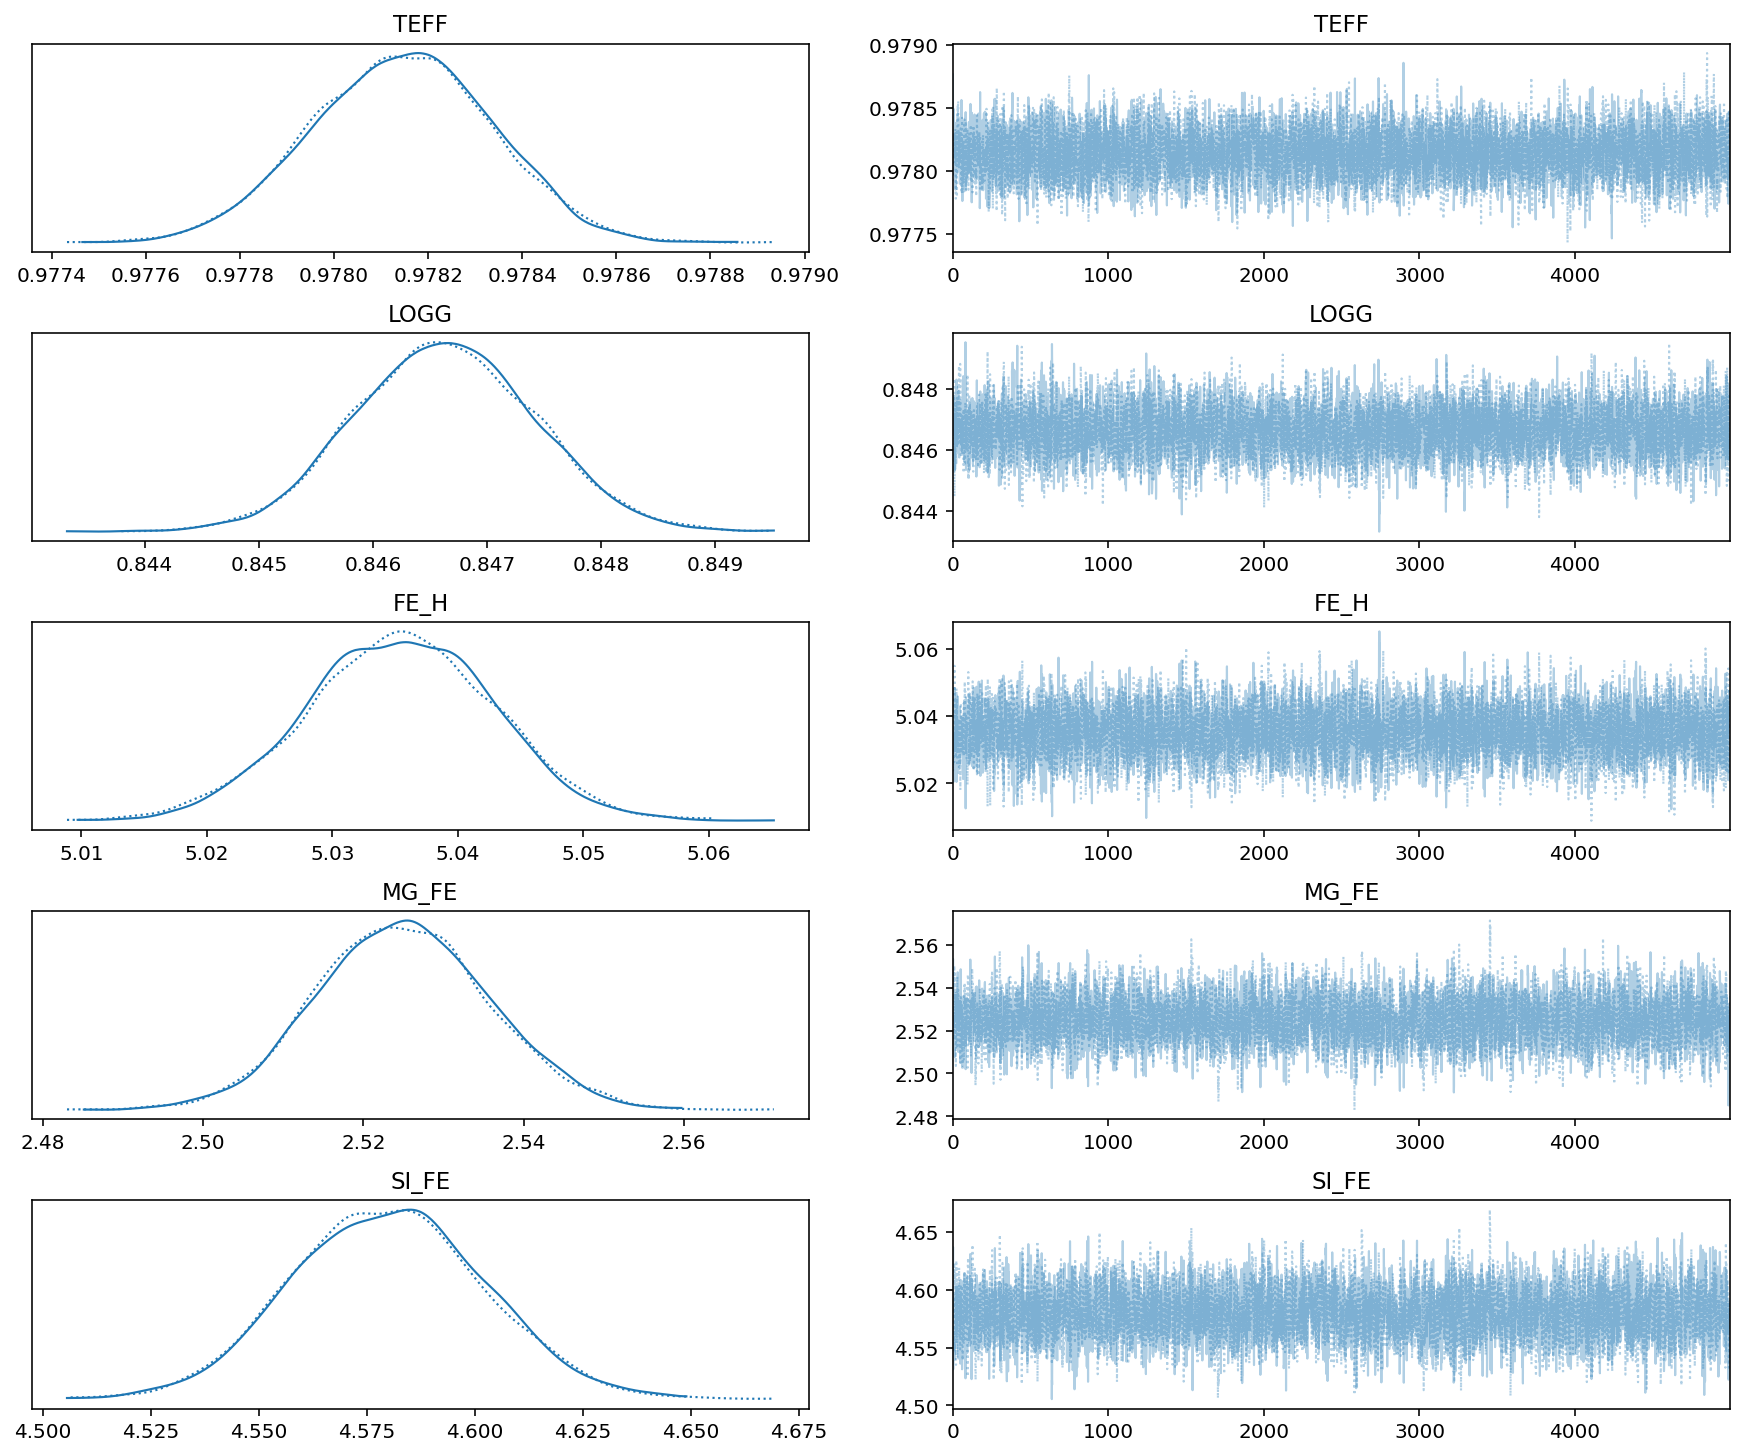

In [87]:
# thanks to Anup Hiremath for helping me get this working
%config InlineBackend.figure_format = 'retina'
with pm.Model() as model:
    #print("starting priors")
    teff = pm.Normal("TEFF", mu=1, sd=10)
    logg = pm.Normal("LOGG", mu=1, sd=10)
    fe_h = pm.Normal("FE_H", mu=1, sd=10)
    mg_fe= pm.Normal("MG_FE", mu=1, sd=10)
    si_fe= pm.Normal("SI_FE", mu=1, sd=10)
    #print("done with priors")
    
    #print("starting labels")
    labels = make_vector_2(teff, logg, fe_h, mg_fe, si_fe)
    #print("finished labels")
    
    est_flux = pm.math.dot(all_coeff, labels)#all_coeff.dot(labels)
    #print("starting log likely")
    log_likely = -0.5*((m_normed_flux - est_flux)**2/(total_sigma)) - 0.5*(np.log(total_sigma))
    
    #print("starting likelihood")
    likelihood = pm.Potential("likelihood", log_likely)
    
    #print("hello")
    trace = pm.sample(draws=5000, tune=1000, init="adapt_diag", step=pm.NUTS())
    
corner_stuff = pm.traceplot(trace, var_names=["TEFF", "LOGG", "FE_H", "MG_FE", "SI_FE"])
pm.summary(trace, var_names=["TEFF", "LOGG", "FE_H", "MG_FE", "SI_FE"])

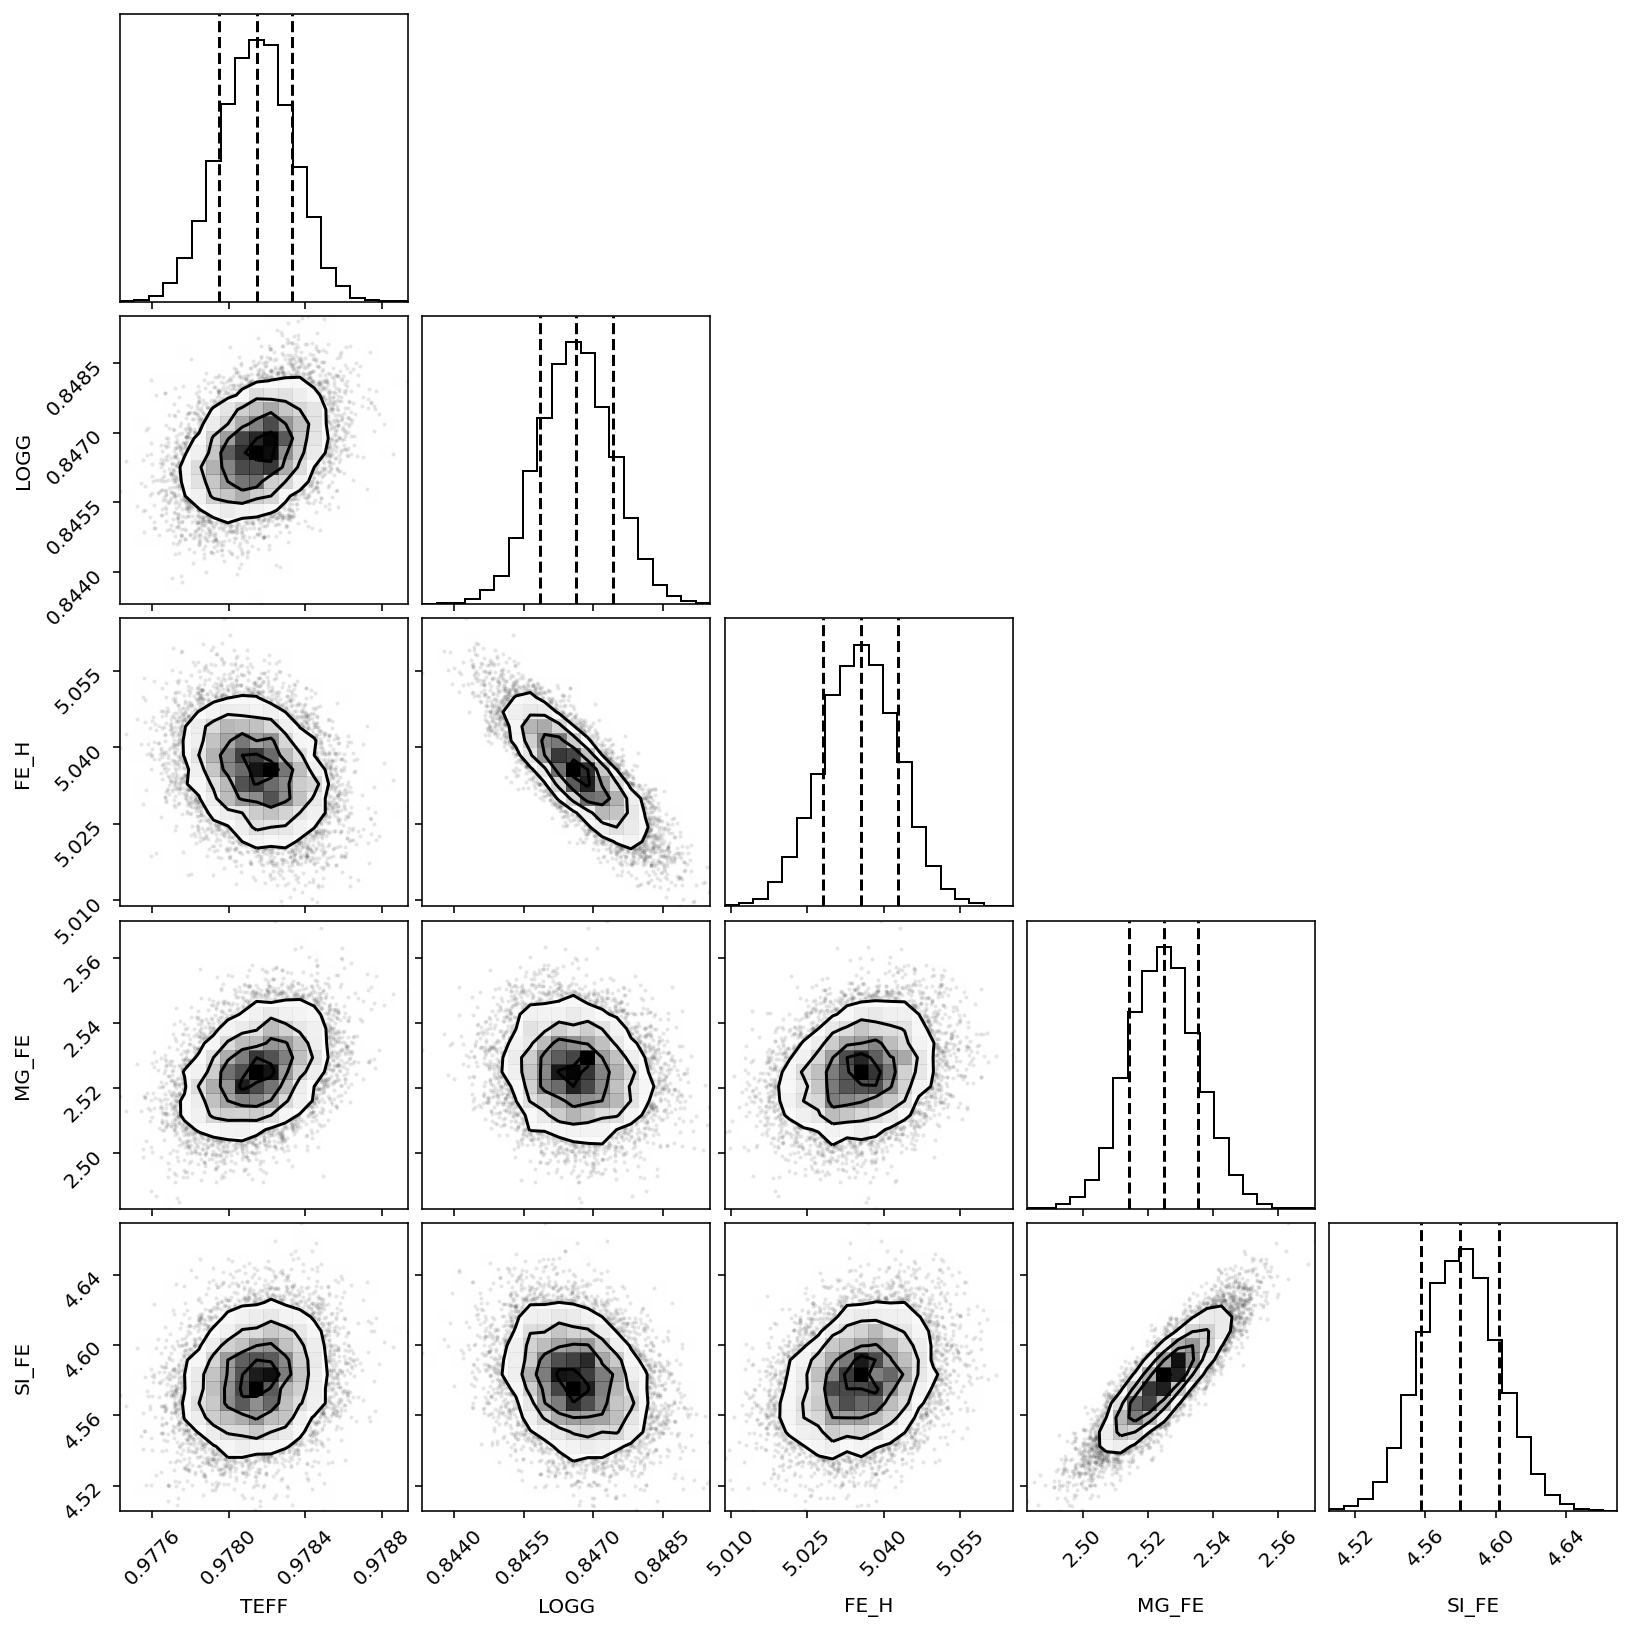

In [88]:
samples = pm.trace_to_dataframe(trace, varnames=["TEFF", "LOGG", "FE_H", "MG_FE", "SI_FE"])
_ = corner.corner(samples, quantiles=[.16, .50, .84])

In [108]:
mcmc_tbl = pm.summary(trace, var_names=["TEFF", "LOGG", "FE_H", "MG_FE", "SI_FE"])
mcmc_means = mcmc_tbl["mean"]
mcmc_sds = mcmc_tbl["sd"]

/Users/DanielBautista/opt/miniconda3/envs/astroconda/lib/python3.6/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


In [119]:
real_means = mcmc_means*LABEL_MEANS
real_means

TEFF     4506.948249
LOGG        2.000601
FE_H       -0.584667
MG_FE       0.209276
SI_FE       0.177048
Name: mean, dtype: float64

In [120]:
real_sds = mcmc_sds*LABEL_MEANS
real_sds

TEFF     0.000000
LOGG     0.002362
FE_H    -0.000813
MG_FE    0.000912
SI_FE    0.000850
Name: sd, dtype: float64

In [123]:
labels = ["TEFF", "LOGG", "FE_H", "MG_FE", "SI_FE"]

for label in labels:
    ascap_err = np.mean(all_tables[label+"_ERR"])
    mcmc_err = real_sds[label]
    ratio = np.abs(ascap_err/mcmc_err)
    print("The ascap error is %s times larger than that of the MCMC"%ratio)

The ascap error is inf times larger than that of the MCMC
The ascap error is 22.720559790266964 times larger than that of the MCMC
The ascap error is 12.242930626309837 times larger than that of the MCMC
The ascap error is 14.85711330989775 times larger than that of the MCMC
The ascap error is 15.017040382064522 times larger than that of the MCMC


Looking at the results of the MCMC fit, my uncertainties seem to 10-20 times smaller than the uncertainties in the ASCAP labels. They are also much smaller than the scatter from the cross validaton. I addtibute the very small uncertainty in the MCMC values to the fact that the values are a result of finding values that maximize the likelihood, which, with enough draws, will resiult in a very small range of values. This sampling technique only incorporates the errors when calculating the likelihood, whereas the ASCAP labels include the uncertainty in the measurements made by the instruments, which sampling in likelihood-space may get rid of.

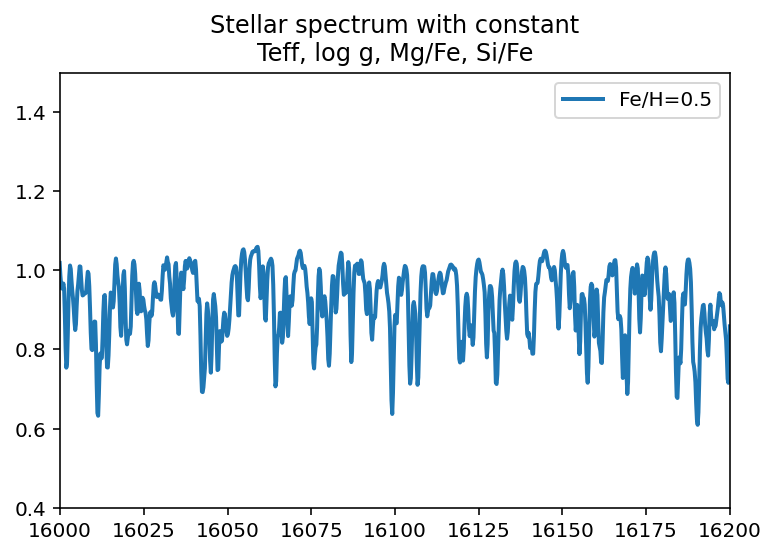

In [128]:
slides=100
my_title = "Stellar spectrum with constant\nTeff, log g, Mg/Fe, Si/Fe"

fig = plt.figure()

show_values = np.linspace(-1, 0.5, num=slides)
plot_values = show_values/label_means["FE_H"]

ax = plt.axes(xlim=(16000, 16200), ylim=(0.4,1.5))
line, = ax.plot([], [], lw=2)

def init():
    line.set_data([],[])
    return line, 

def animate(i): # the parameter `i` is the frame number
    labels = make_vector(1, 1, plot_values[i], 1, 1)
    x = wl_range
    y = coeff_range.dot(labels)
    line.set_data(x, y)
    line.set_label("Fe/H=%s"%np.round(show_values[i],3))
    ax.legend()
    ax.set_title(my_title)
    return line, 

anim = animation.FuncAnimation(fig, animate, init_func=init,
                              frames=slides, interval=20, blit=True)

anim.save("vary_Fe_H.mp4", fps=30)
plt.show()

In [129]:
plot_range_tbl = solar_tbl[np.where((solar_tbl["log_g"] >= 0.5) & (solar_tbl["log_g"] <= 3.5))]
show_logg = plot_range_tbl["log_g"]
show_teff = 10**plot_range_tbl["log_Teff"]

plot_teff = show_teff/label_means["TEFF"]
plot_logg = show_logg/label_means["LOGG"]

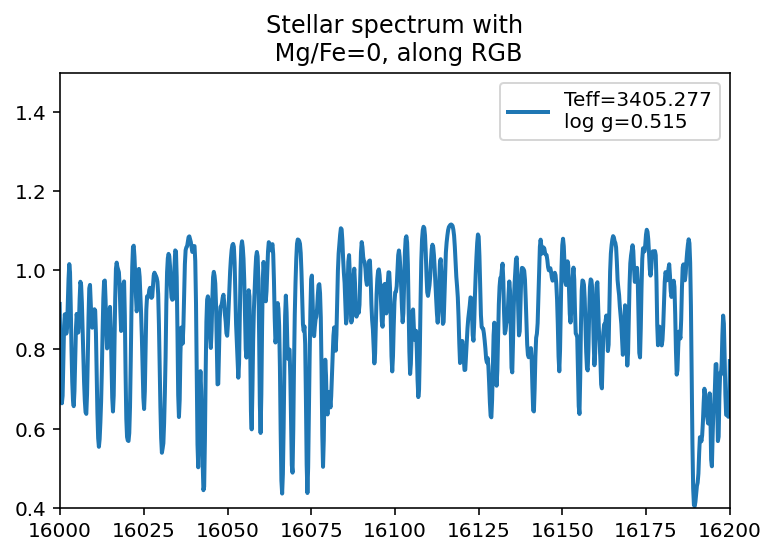

In [130]:
slides=len(show_logg)
my_title = "Stellar spectrum with\n Mg/Fe=0, along RGB"

fig = plt.figure()

ax = plt.axes(xlim=(16000, 16200), ylim=(0.4,1.5))
line, = ax.plot([], [], lw=2)

def init():
    line.set_data([],[])
    return line, 

def animate(i): # the parameter `i` is the frame number
    labels = make_vector(plot_teff[i], plot_logg[i], 0, 1, 1)
    x = wl_range
    y = coeff_range.dot(labels)
    line.set_data(x, y)
    line.set_label("Teff=%s\nlog g=%s"%(np.round(show_teff[i],3),np.round(show_logg[i],3)))
    ax.legend()
    ax.set_title(my_title)
    return line, 

anim = animation.FuncAnimation(fig, animate, init_func=init,
                              frames=slides, interval=20, blit=True)

anim.save("vary_logg.mp4")
plt.show()

In [127]:
label_means

{'TEFF': 4608.3315,
 'LOGG': 2.3619843,
 'FE_H': -0.116120525,
 'MG_FE': 0.08288146,
 'SI_FE': 0.03865677}

When starting with the inital values, the predicted spectra bot look very similar. However as we start to vary the values of the labels, we start to notice some differences. As the metallicity increasdes, while holding the other labels at the mean values of the training data, we see that the absorption features all become more pronounced (deeper). When moving the star up the red giant branch, (decrease Teff and log g) we see that all the spectral features become more pronounced. Regions with higher values of normalized flux become higher, and regions with lower values of normalized flux become deeper. 

One thing that was not considered in my model was the fact that many stars exist in binary systems with another star, for example, a case where there is a white dwarf and a red giant orbiting each other. If the angular separation of this binary system is sufficiently small, the instruments will not be able to resolve the two sources independantly, and will record a spectrum that should really be the sum of two spectra. This will result in a best fit model that performs poorly due to the combination of spectral features belonging to two different stars. The combined fluxes will result in a higher flux measurement which would make the "star" appear more luminous (hotter and/or larger) than either of its constituents. Additionally, white dwarves have a higher metallicity than a red giant, which could give this star a higher derived metallicity, than what it should be. But combining this with the higher flux contribution of the red giant, would result in a "star" that has a less prominent absorption features. 

In order to correct for this, one would have to develop a model that determines the properties of the pair of stars based on the superposition of their spectra. 

In [93]:
import math
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

In [133]:
# turn my broken up chips into a single flux arra
len(train_data), len(validation_data)

(928, 927)

In [143]:
def XXXX_data_condense(dataset):
    train_flux, train_labels = [],[]
    for source in dataset:
        all_flux = np.asarray([])
        for chip in source[1]:
            all_flux = np.append(all_flux, chip)
        the_labels = np.asarray([source[2]["TEFF"], source[2]["LOGG"], source[2]["FE_H"], source[2]["MG_FE"], source[2]["SI_FE"]])
        train_flux.append(all_flux)
        train_labels.append(the_labels)
    train_labels = np.asarray(train_labels)
    train_flux = np.asarray(train_flux)
    return train_flux, train_labels

In [152]:
train_flux, train_labels = XXXX_data_condense(train_data)
test_flux, test_labels = XXXX_data_condense(validation_data)

In [153]:
import tensorflow.keras.backend as K
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense

In [155]:
X = K.constant(train_flux)
y = K.constant(train_labels)

In [160]:
model = Sequential()
model.add(Dense(32, input_dim=7451, activation="relu", kernel_initializer='random_uniform'))
model.add(Dense(32, activation="relu", kernel_initializer='random_uniform'))
model.add(Dense(5, activation="linear", kernel_initializer='random_uniform'))
model.compile(optimizer="adam", loss="mean_squared_error", metrics=["accuracy"])

In [197]:
history = model.fit(X, y, epochs=100, steps_per_epoch=10)

Epoch 1/100
10/10 [==============================] - 0s 46ms/step - loss: 0.8652 - accuracy: 0.5642
Epoch 2/100
10/10 [==============================] - 0s 45ms/step - loss: 0.8629 - accuracy: 0.5650
Epoch 3/100
10/10 [==============================] - 0s 43ms/step - loss: 0.8947 - accuracy: 0.5544
Epoch 4/100
10/10 [==============================] - 0s 46ms/step - loss: 0.8589 - accuracy: 0.5651
Epoch 5/100
10/10 [==============================] - 1s 58ms/step - loss: 0.9362 - accuracy: 0.5391
Epoch 6/100
10/10 [==============================] - 1s 58ms/step - loss: 0.8743 - accuracy: 0.5518
Epoch 7/100
10/10 [==============================] - 1s 112ms/step - loss: 0.8440 - accuracy: 0.5667
Epoch 8/100
10/10 [==============================] - 1s 97ms/step - loss: 0.8538 - accuracy: 0.5669
Epoch 9/100
10/10 [==============================] - 1s 56ms/step - loss: 0.8620 - accuracy: 0.5616
Epoch 10/100
10/10 [==============================] - 1s 77ms/step - loss: 0.8956 - accuracy: 0.543

10/10 [==============================] - 1s 88ms/step - loss: 0.5568 - accuracy: 0.6829
Epoch 83/100
10/10 [==============================] - 1s 68ms/step - loss: 0.5596 - accuracy: 0.6849
Epoch 84/100
10/10 [==============================] - 1s 82ms/step - loss: 0.5342 - accuracy: 0.6943
Epoch 85/100
10/10 [==============================] - 0s 46ms/step - loss: 0.6215 - accuracy: 0.6649
Epoch 86/100
10/10 [==============================] - 1s 65ms/step - loss: 0.5510 - accuracy: 0.6795
Epoch 87/100
10/10 [==============================] - 0s 44ms/step - loss: 0.5272 - accuracy: 0.6987
Epoch 88/100
10/10 [==============================] - 0s 40ms/step - loss: 0.5849 - accuracy: 0.6789
Epoch 89/100
10/10 [==============================] - 0s 40ms/step - loss: 0.5281 - accuracy: 0.6902
Epoch 90/100
10/10 [==============================] - 0s 43ms/step - loss: 0.5404 - accuracy: 0.6923
Epoch 91/100
10/10 [==============================] - 0s 45ms/step - loss: 0.5408 - accuracy: 0.6906
Epo

In [198]:
test_X = K.constant(test_flux)
test_y = K.constant(test_labels)

In [213]:
best_fit_params = model.predict(test_X, steps=1)

In [214]:
best_fit_params.shape, test_labels.shape

((927, 5), (927, 5))

In [212]:
def get_labels(params, label_indx):
    label_vals =[]
    for sublist in params:
        label_vals.append(sublist[label_indx])
    return np.asarray(label_vals)

Looking at the scatter plots of the ASCAP labels vs the labels inferred by the neural network, I can see that it does a fairly good job at estimating the label values, but the model fitting I did earlier appears to have performed better. In general the scatter from the neural net appears to be higher than that from problem 9. I have a feeling that a large amount of this has to do with the fact that I am very new to using neural nets and don't have all the techniques needed to make use of them to their full potential 

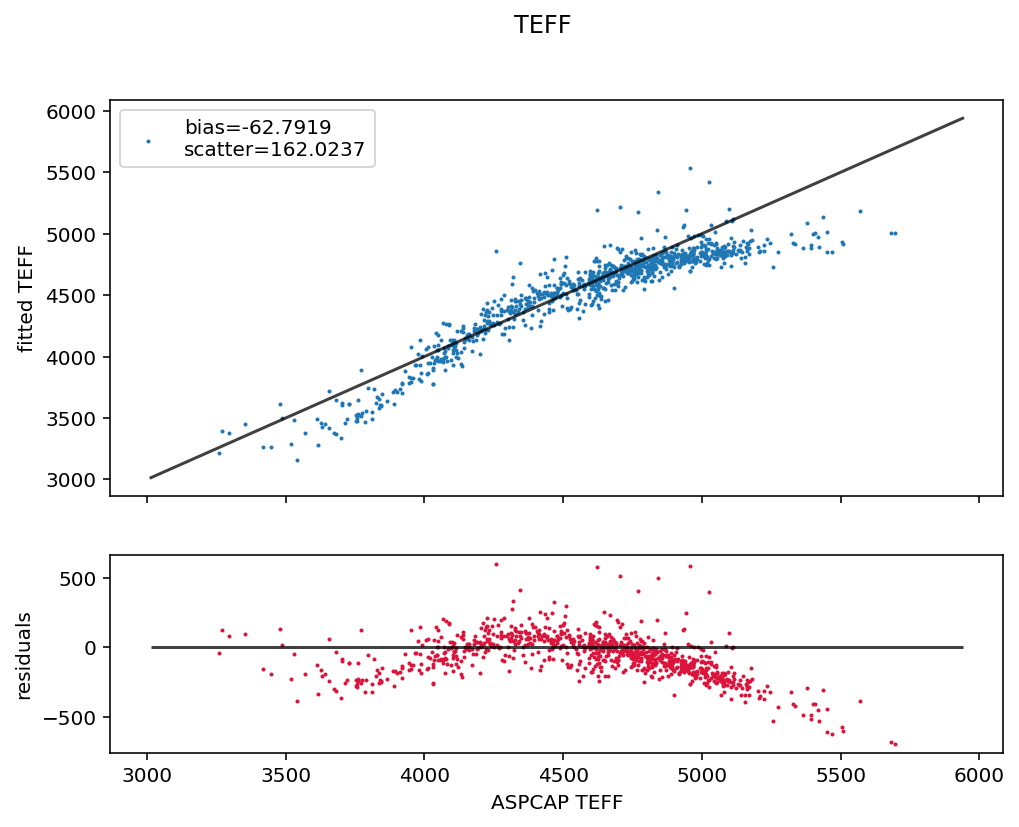

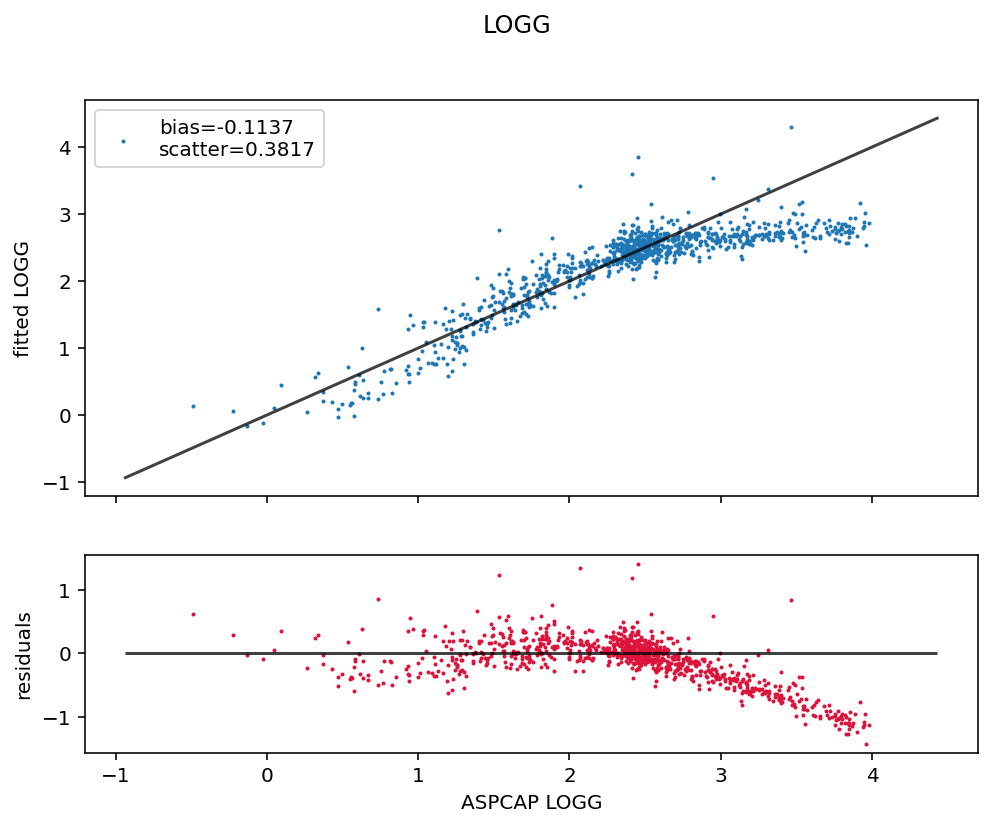

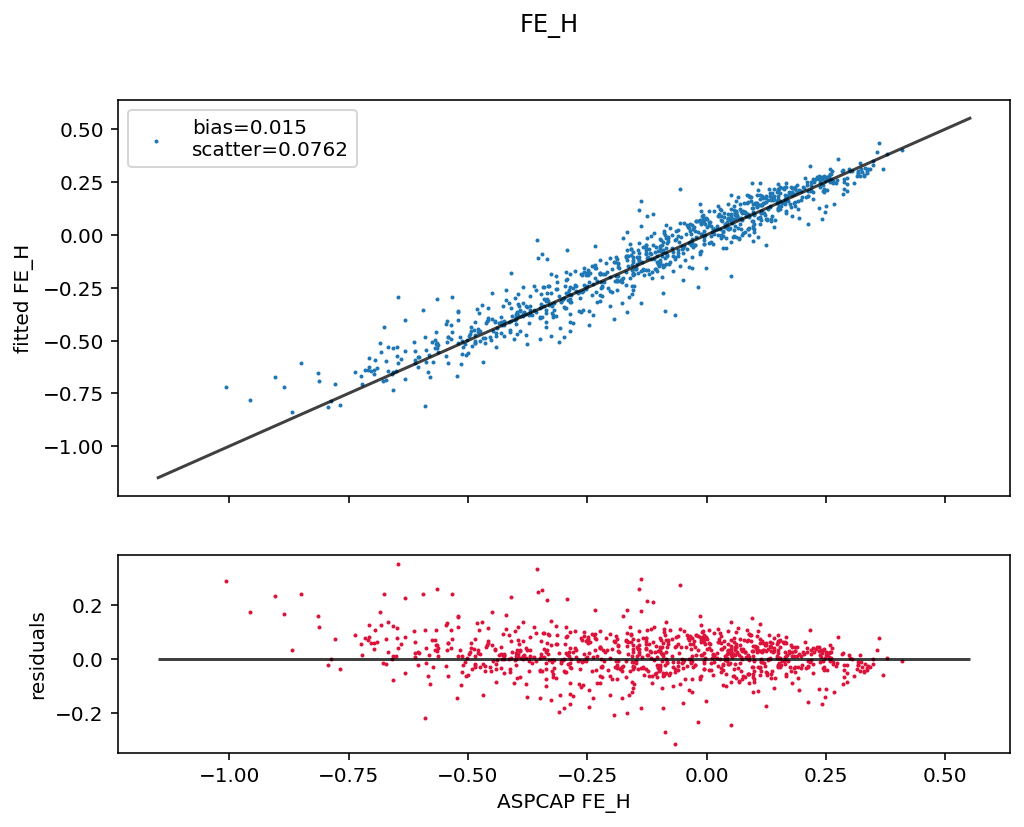

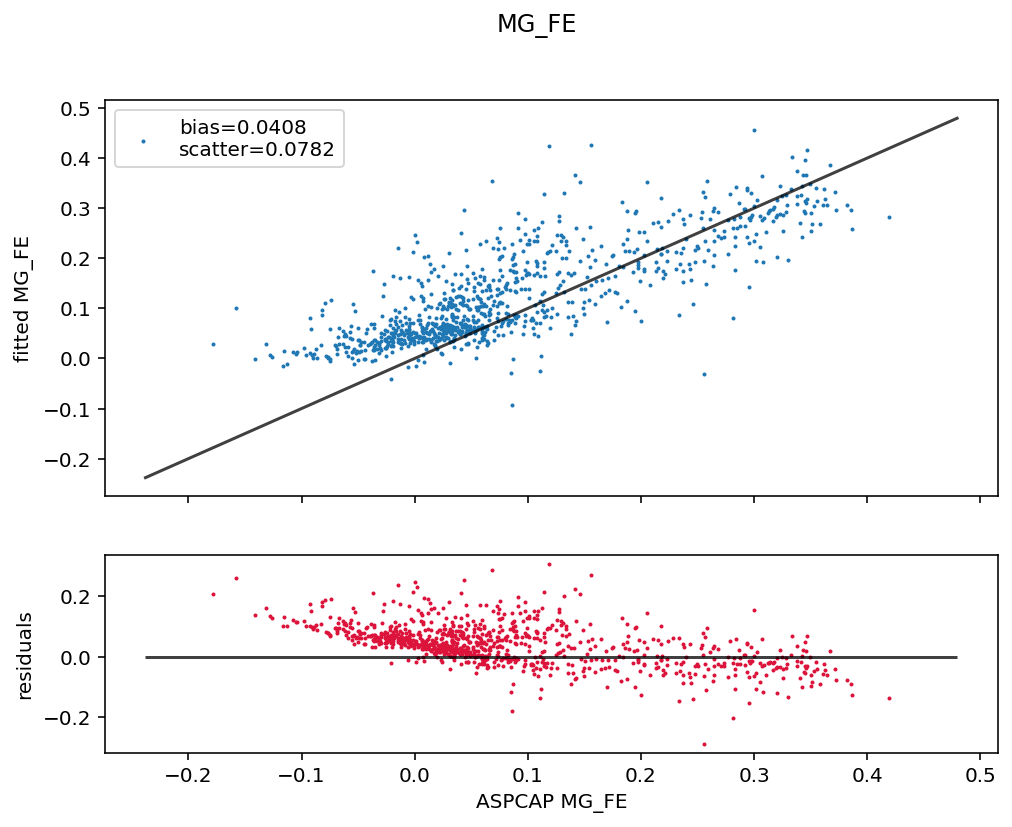

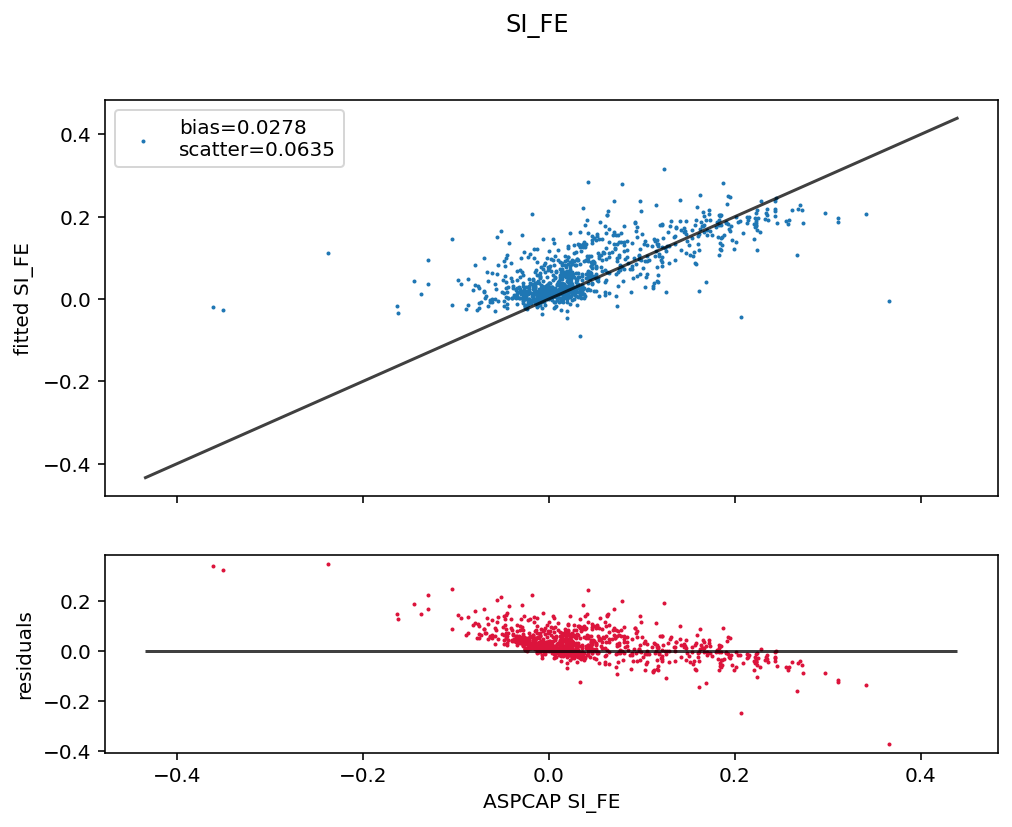

In [218]:
for label in labels:
    plot_and_residuals(label, best_fit_params, test_labels)